# Preprocessing

## Packages

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np 
import torch

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style
set_style("whitegrid")

## Load data

In [2]:
tech = pd.read_csv("../data/tech_data.csv", parse_dates=True)
biotech = pd.read_csv("../data/biotech_data.csv", parse_dates=True)
healthcare = pd.read_csv("../data/healthcare_data.csv", parse_dates=True)
industrial = pd.read_csv("../data/industrial_data.csv", parse_dates=True)

In [3]:
## get the tickers
tech_tickers = list(tech.columns[1:])
biotech_tickers = list(biotech.columns[1:])
healthcare_tickers = list(healthcare.columns[1:])
industrial_tickers = list(industrial.columns[1:])

for i in range(5):
    ## tech stocks
    tech[f"{tech_tickers[i]}_returns"] = np.log(tech[tech_tickers[i]]) - np.log(tech[tech_tickers[i]].shift(-1))
    tech[f"{tech_tickers[i]}_volatility"] = tech[f"{tech_tickers[i]}_returns"].rolling(30).std()

    ## biotech stocks
    biotech[f"{biotech_tickers[i]}_returns"] = np.log(biotech[biotech_tickers[i]]) - np.log(biotech[biotech_tickers[i]].shift(-1))
    biotech[f"{biotech_tickers[i]}_volatility"] = biotech[f"{biotech_tickers[i]}_returns"].rolling(30).std()

    ## healthcare stocks
    healthcare[f"{healthcare_tickers[i]}_returns"] = np.log(healthcare[healthcare_tickers[i]]) - np.log(healthcare[healthcare_tickers[i]].shift(-1))
    healthcare[f"{healthcare_tickers[i]}_volatility"] = healthcare[f"{healthcare_tickers[i]}_returns"].rolling(30).std()

    ## industrial stocks
    industrial[f"{industrial_tickers[i]}_returns"] = np.log(industrial[industrial_tickers[i]]) - np.log(industrial[industrial_tickers[i]].shift(-1))
    industrial[f"{industrial_tickers[i]}_volatility"] = industrial[f"{industrial_tickers[i]}_returns"].rolling(30).std()


## remove missing values
tech.dropna(inplace=True)
biotech.dropna(inplace=True)
healthcare.dropna(inplace=True)
industrial.dropna(inplace=True)

## reset the index
tech.reset_index(inplace=True, drop=True)
biotech.reset_index(inplace=True, drop=True)
healthcare.reset_index(inplace=True, drop=True)
industrial.reset_index(inplace=True, drop=True)

## Create train, val, test split and convert to torch tensors

In [4]:
from utils.dataset_factory import train_val_test_split

In [5]:
tech_train, tech_val, tech_test = train_val_test_split(tech, val_ratio=0.15, test_ratio=0.15)
biotech_train, biotech_val, biotech_test = train_val_test_split(biotech, val_ratio=0.15, test_ratio=0.15)
healthcare_train, healthcare_val, healthcare_test = train_val_test_split(healthcare, val_ratio=0.15, test_ratio=0.15)
industrial_train, industrial_val, industrial_test = train_val_test_split(industrial, val_ratio=0.15, test_ratio=0.15)

# LSTM Fitting

In [6]:
from model.volatility_lstm import VolatilityLSTM
from single_experiment import train_model, test_model

MODEL_CONFIGS = {
    "window_size": 10,
    "lstm_hidden_size": 256,
    "n_lstm_layers": 2,
    "dense_hidden_sizes": [128, 32],
    "n_dense_layers": 2,
    "dropout": 0.0,
    "dropout_lstm": False
}

TRAIN_CONFIG = {
    'patience': 20,
    'max_iter': 1000
}

In [7]:
## empty dictionaries to hold the average MSES, models, mean, and std for each stock
tech_results = {}
tech_models = {}
tech_means = {}
tech_stds = {}

for stock in tech_tickers:
    print(f'Start training {stock}')
    start_time = datetime.now()
    
    train_tensor = torch.tensor(tech_train[f'{stock}_volatility'].values, dtype=torch.float)
    mean, std = train_tensor.mean().item(), train_tensor.std().item()
    train_tensor = (train_tensor - mean) / std
    tech_means[stock] = mean
    tech_stds[stock] = std
    
    val_tensor = torch.tensor(tech_val[f'{stock}_volatility'].values, dtype=torch.float)
    val_tensor = (val_tensor - mean) / std
    
    X_train = train_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
    y_train = train_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)
    
    X_val = val_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
    y_val = val_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)
    
    model = VolatilityLSTM(**MODEL_CONFIGS)
    
    best_model, best_val_loss, total_epochs = train_model(model,
                                                          X_train,
                                                          y_train,
                                                          X_val,
                                                          y_val,
                                                          **TRAIN_CONFIG)
    
    tech_results[stock] = best_val_loss
    tech_models[stock] = best_model
    
    end_time = datetime.now()
    
    print(f'Done training {stock} for {total_epochs} epochs\tTook {end_time-start_time}')
    

Start training AAPL
Done training AAPL for 402 epochs	Took 0:01:12.790318
Start training AMZN
Done training AMZN for 274 epochs	Took 0:00:49.628276
Start training GOOGL
Done training GOOGL for 345 epochs	Took 0:01:02.638911
Start training MSFT
Done training MSFT for 337 epochs	Took 0:01:02.151633
Start training NVDA
Done training NVDA for 319 epochs	Took 0:00:59.611612


In [8]:
def print_results(stock_results):
    print('Stock\tValidation MSE')
    for stock, val_mse in stock_results.items():
        print(f'{stock}\t{val_mse}')

In [9]:
print_results(tech_results)

Stock	Validation MSE
AAPL	3.2525861263275146
AMZN	0.31698596477508545
GOOGL	2.035010814666748
MSFT	5.1315789222717285
NVDA	1.0393565893173218


In [10]:
## empty dictionaries to hold the average MSES, models, mean, and std for each stock
biotech_results = {}
biotech_models = {}
biotech_means = {}
biotech_stds = {}

for stock in biotech_tickers:
    print(f'Start training {stock}')
    start_time = datetime.now()
    
    train_tensor = torch.tensor(biotech_train[f'{stock}_volatility'].values, dtype=torch.float)
    mean, std = train_tensor.mean().item(), train_tensor.std().item()
    train_tensor = (train_tensor - mean) / std
    biotech_means[stock] = mean
    biotech_stds[stock] = std
    
    val_tensor = torch.tensor(biotech_val[f'{stock}_volatility'].values, dtype=torch.float)
    val_tensor = (val_tensor - mean) / std
    
    X_train = train_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
    y_train = train_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)
    
    X_val = val_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
    y_val = val_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)
    
    model = VolatilityLSTM(**MODEL_CONFIGS)
    
    best_model, best_val_loss, total_epochs = train_model(model,
                                                          X_train,
                                                          y_train,
                                                          X_val,
                                                          y_val,
                                                          **TRAIN_CONFIG)
    
    biotech_results[stock] = best_val_loss
    biotech_models[stock] = best_model
    
    end_time = datetime.now()
    
    print(f'Done training {stock} for {total_epochs} epochs\tTook {end_time-start_time}')
    

Start training JNJ
Done training JNJ for 374 epochs	Took 0:01:09.254409
Start training LLY
Done training LLY for 503 epochs	Took 0:01:31.944647
Start training MRK
Done training MRK for 396 epochs	Took 0:01:12.059870
Start training NVO
Done training NVO for 293 epochs	Took 0:00:53.413140
Start training RHHBY
Done training RHHBY for 424 epochs	Took 0:01:17.055215


In [11]:
print_results(biotech_results)

Stock	Validation MSE
JNJ	5.821925640106201
LLY	5.26681661605835
MRK	3.4810924530029297
NVO	0.9123395681381226
RHHBY	5.493588924407959


In [12]:
## empty dictionaries to hold the average MSES, models, mean, and std for each stock
healthcare_results = {}
healthcare_models = {}
healthcare_means = {}
healthcare_stds = {}

for stock in healthcare_tickers:
    print(f'Start training {stock}')
    start_time = datetime.now()
    
    train_tensor = torch.tensor(healthcare_train[f'{stock}_volatility'].values, dtype=torch.float)
    mean, std = train_tensor.mean().item(), train_tensor.std().item()
    train_tensor = (train_tensor - mean) / std
    healthcare_means[stock] = mean
    healthcare_stds[stock] = std
    
    val_tensor = torch.tensor(healthcare_val[f'{stock}_volatility'].values, dtype=torch.float)
    val_tensor = (val_tensor - mean) / std
    
    X_train = train_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
    y_train = train_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)
    
    X_val = val_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
    y_val = val_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)
    
    model = VolatilityLSTM(**MODEL_CONFIGS)
    
    best_model, best_val_loss, total_epochs = train_model(model,
                                                          X_train,
                                                          y_train,
                                                          X_val,
                                                          y_val,
                                                          **TRAIN_CONFIG)
    
    healthcare_results[stock] = best_val_loss
    healthcare_models[stock] = best_model
    
    end_time = datetime.now()
    
    print(f'Done training {stock} for {total_epochs} epochs\tTook {end_time-start_time}')
    

Start training AMGN
Done training AMGN for 458 epochs	Took 0:01:23.691460
Start training CVS
Done training CVS for 373 epochs	Took 0:01:07.692110
Start training ELV
Done training ELV for 516 epochs	Took 0:01:35.035955
Start training PFE
Done training PFE for 456 epochs	Took 0:01:23.174508
Start training UNH
Done training UNH for 405 epochs	Took 0:01:21.318625


In [13]:
print_results(healthcare_results)

Stock	Validation MSE
AMGN	3.480771780014038
CVS	4.205420970916748
ELV	11.325899124145508
PFE	3.878269910812378
UNH	9.805395126342773


In [14]:
## empty dictionaries to hold the average MSES, models, mean, and std for each stock
industrial_results = {}
industrial_models = {}
industrial_means = {}
industrial_stds = {}

for stock in industrial_tickers:
    print(f'Start training {stock}')
    start_time = datetime.now()
    
    train_tensor = torch.tensor(industrial_train[f'{stock}_volatility'].values, dtype=torch.float)
    mean, std = train_tensor.mean().item(), train_tensor.std().item()
    train_tensor = (train_tensor - mean) / std
    industrial_means[stock] = mean
    industrial_stds[stock] = std
    
    val_tensor = torch.tensor(industrial_val[f'{stock}_volatility'].values, dtype=torch.float)
    val_tensor = (val_tensor - mean) / std
    
    X_train = train_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
    y_train = train_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)
    
    X_val = val_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
    y_val = val_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)
    
    model = VolatilityLSTM(**MODEL_CONFIGS)
    
    best_model, best_val_loss, total_epochs = train_model(model,
                                                          X_train,
                                                          y_train,
                                                          X_val,
                                                          y_val,
                                                          **TRAIN_CONFIG)
    
    industrial_results[stock] = best_val_loss
    industrial_models[stock] = best_model
    
    end_time = datetime.now()
    
    print(f'Done training {stock} for {total_epochs} epochs\tTook {end_time-start_time}')
    

Start training F
Done training F for 401 epochs	Took 0:01:21.911379
Start training GE
Done training GE for 847 epochs	Took 0:02:53.151250
Start training NEE
Done training NEE for 379 epochs	Took 0:01:16.941782
Start training SO
Done training SO for 661 epochs	Took 0:02:14.970065
Start training UNP
Done training UNP for 341 epochs	Took 0:01:09.001528


In [15]:
print_results(industrial_results)

Stock	Validation MSE
F	5.007791519165039
GE	5.680093288421631
NEE	17.605152130126953
SO	43.158531188964844
UNP	4.812341690063477


# Evaluating Forecasts

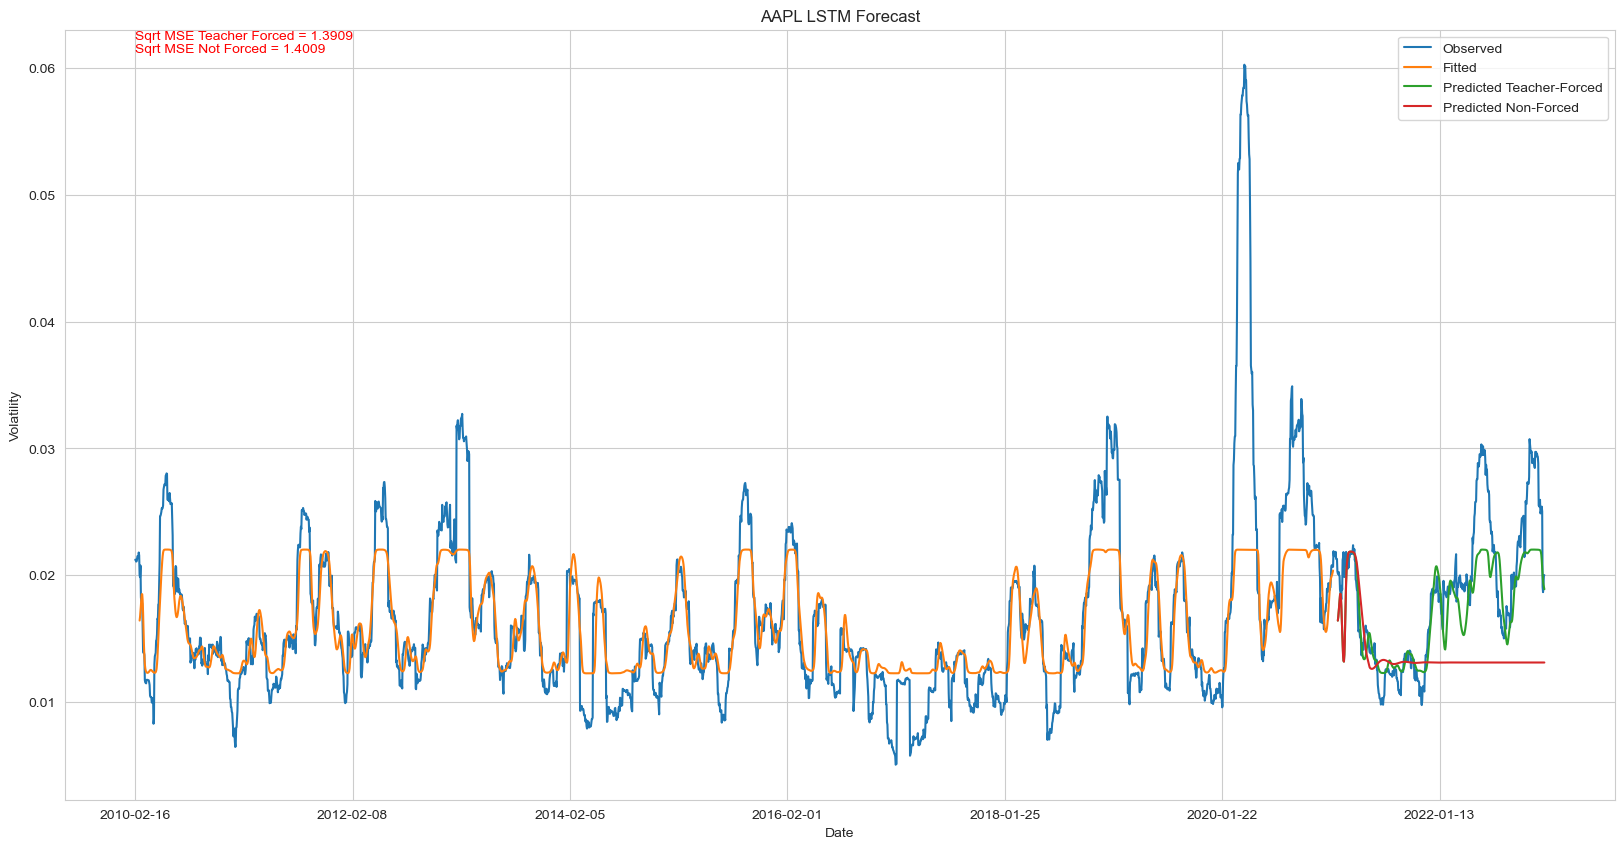

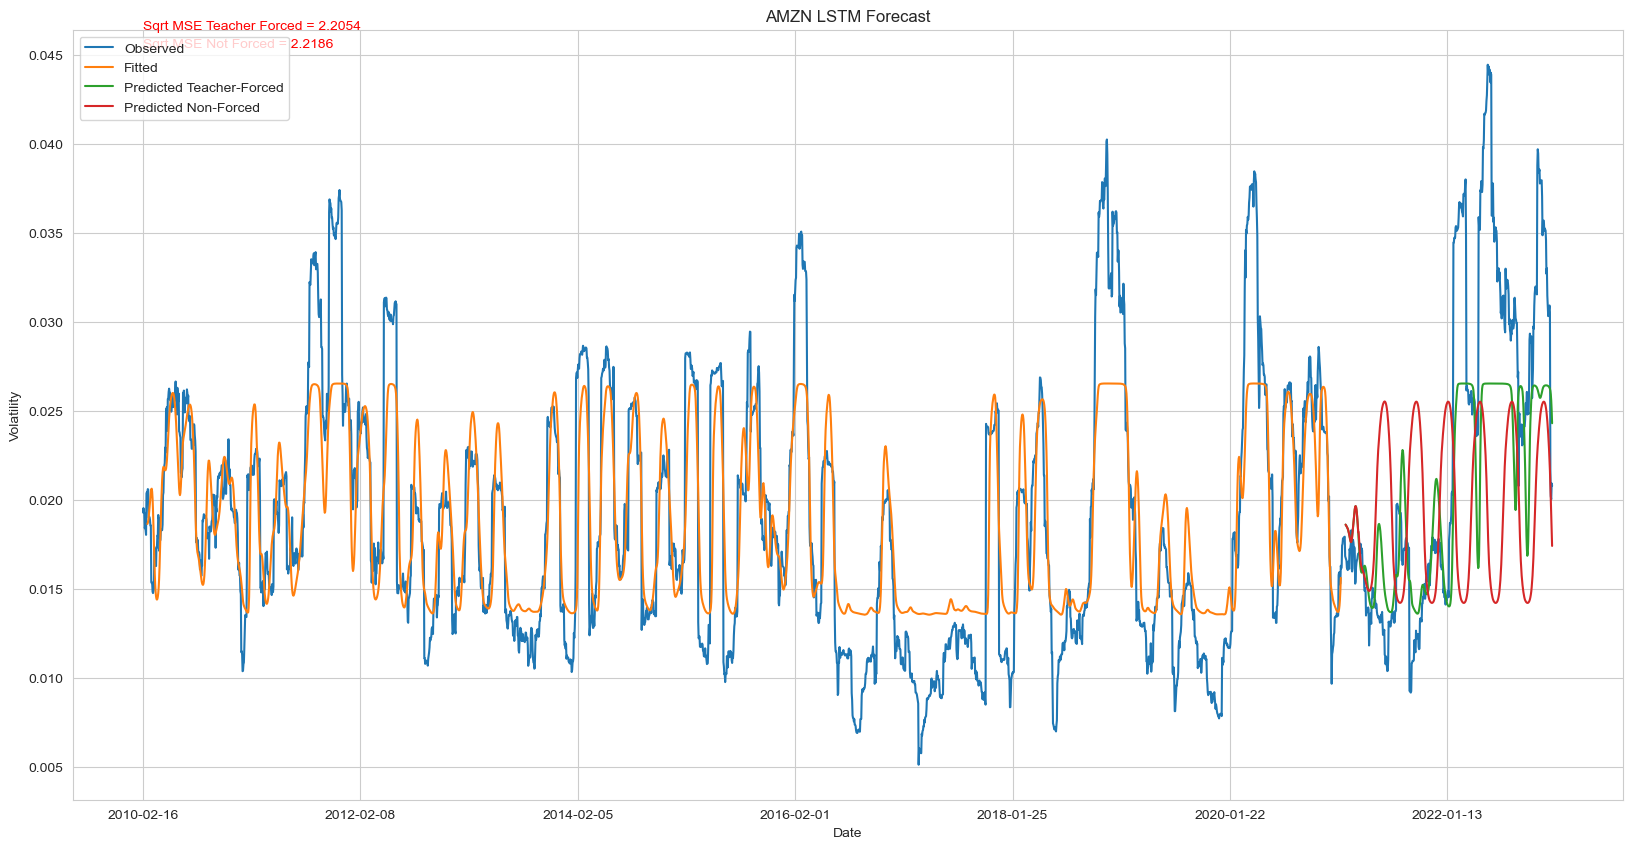

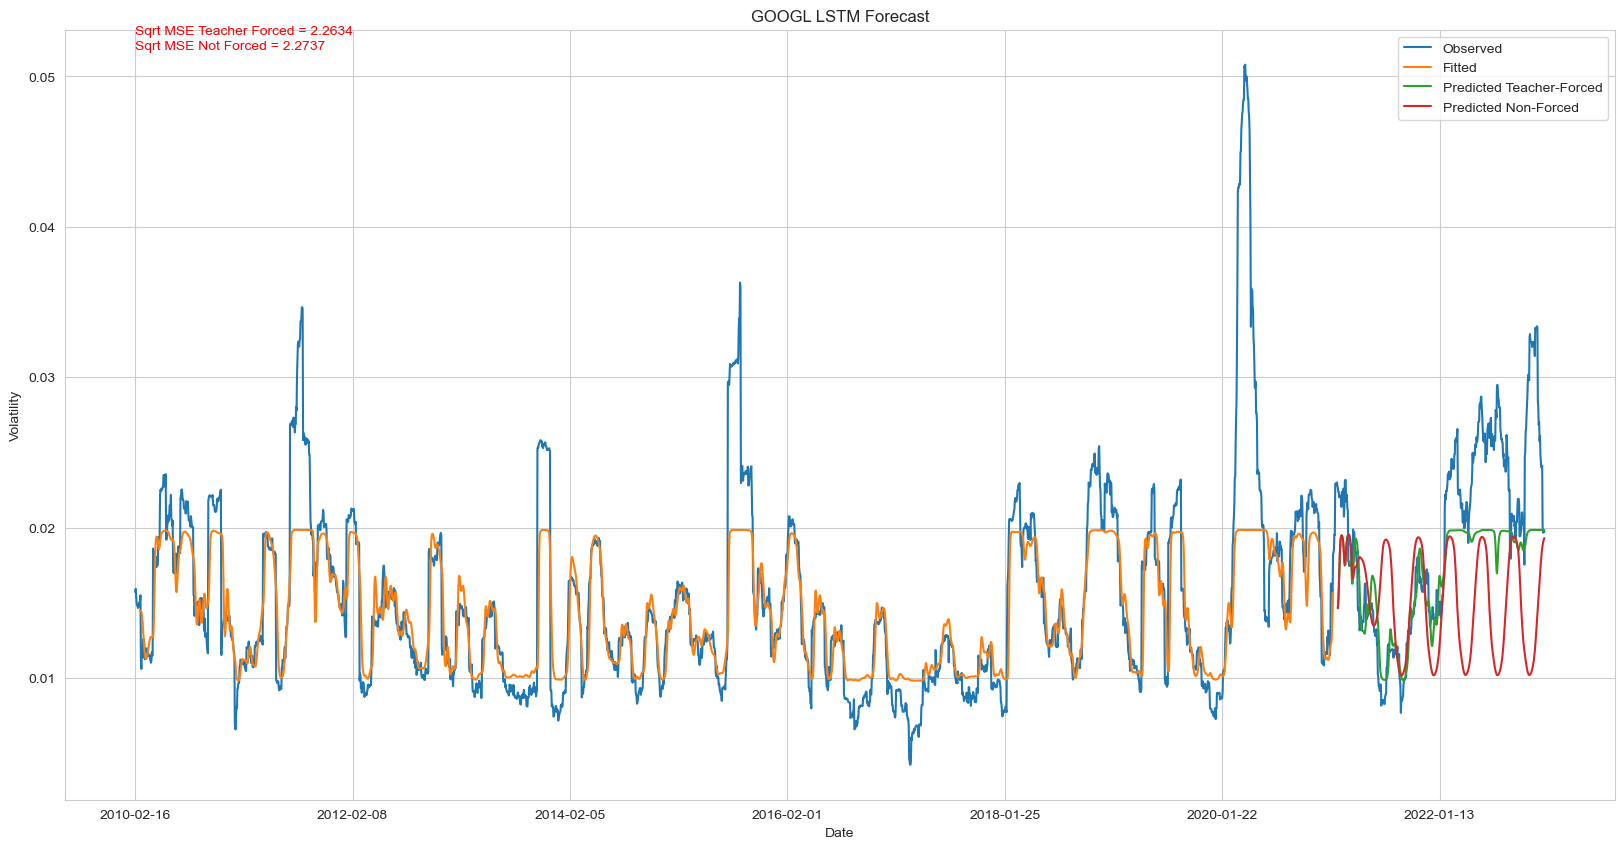

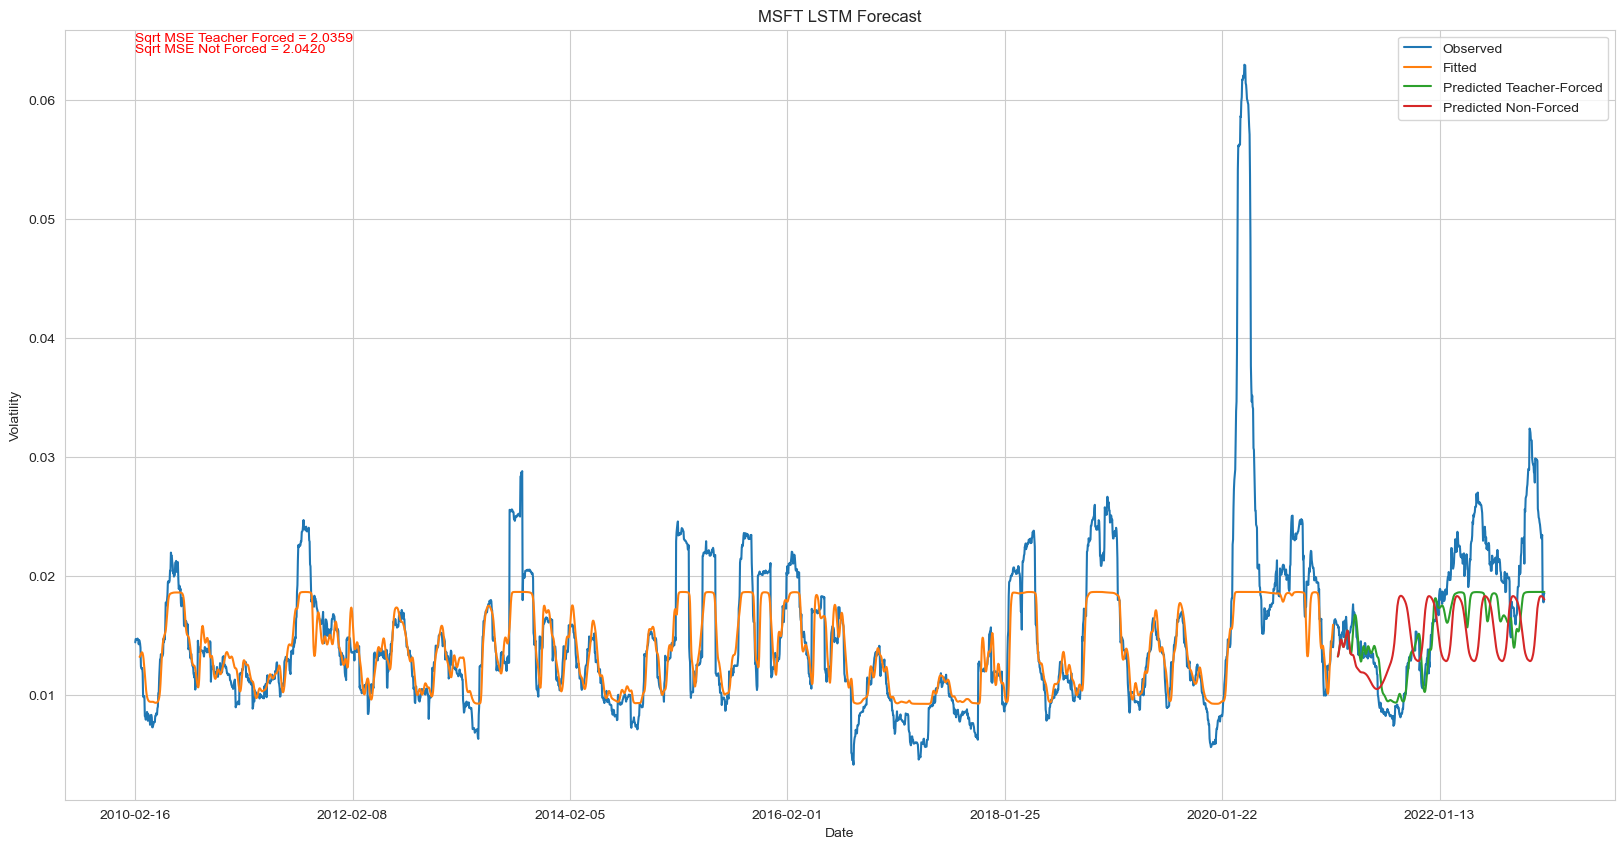

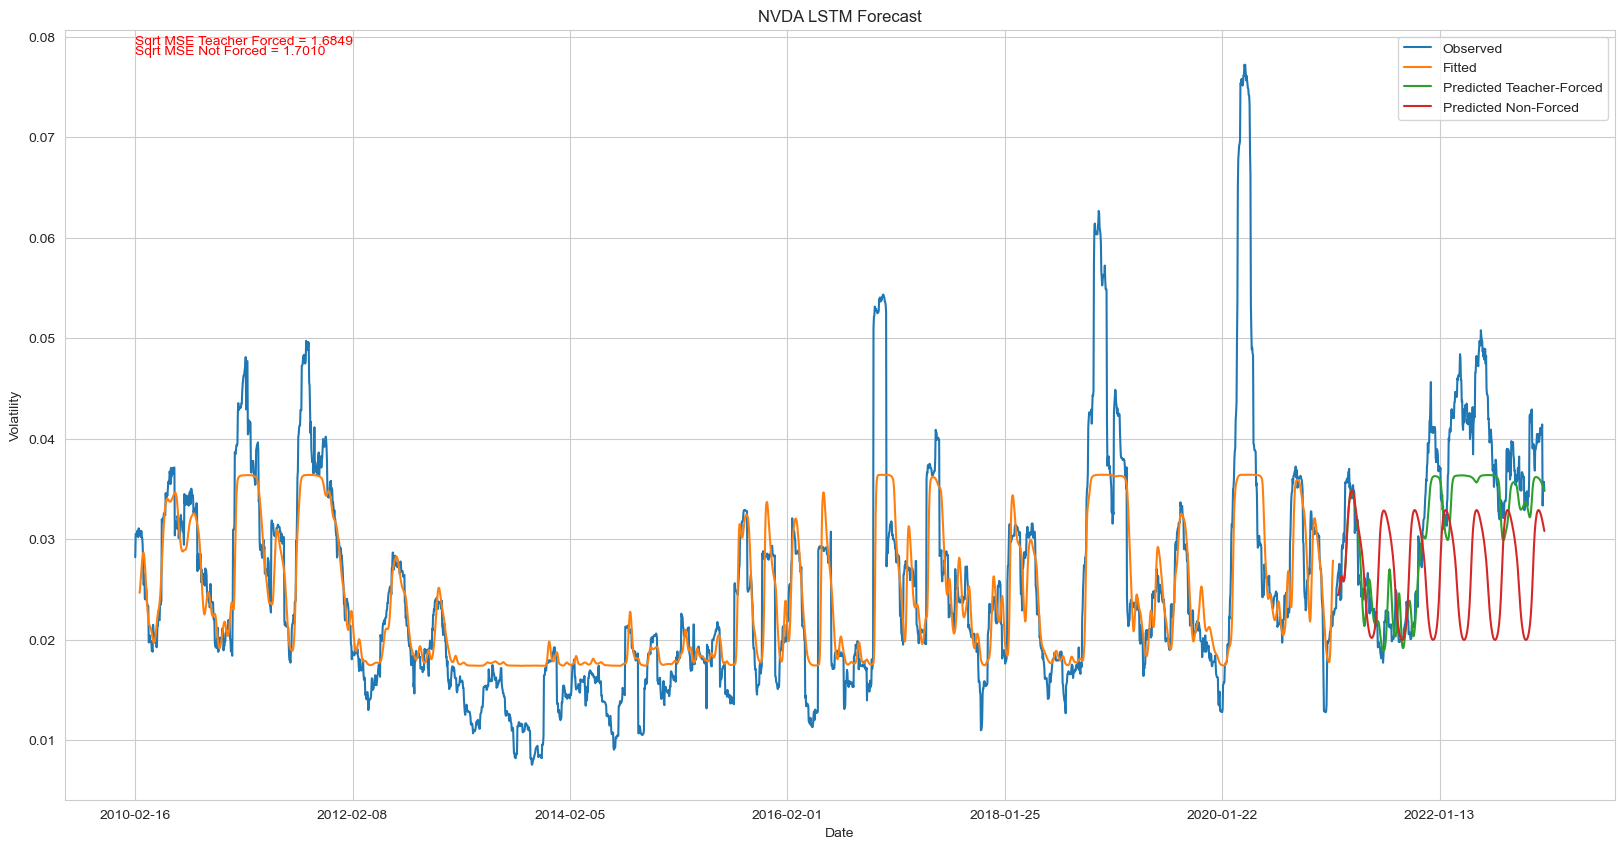

In [16]:
tech_test_mses = {}

with torch.no_grad():
    for stock in tech_tickers:
        window=10

        full_train = pd.concat([tech_train, tech_val])
        train_tensor = torch.tensor(full_train[f'{stock}_volatility'].values, dtype=torch.float)
        mean, std = tech_means[stock], tech_stds[stock]
        train_tensor = (train_tensor - mean) / std

        test_tensor = torch.tensor(tech_test[f'{stock}_volatility'].values, dtype=torch.float)
        test_tensor = (test_tensor - mean) / std

        X_train = train_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
        y_train = train_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)

        X_test = test_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
        y_test = test_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)

        model = tech_models[stock]

        fitted, _ = model(X_train)
        pred_forced, _ = model(X_test)
        # predicting the values given a 30 day initial set
        pred_infer = model.predict(X_test[:, :30, :], n_days=y_test.size(1) - 30, keep_init=True)
        
        fitted = (fitted * std) + mean
        pred_forced = (pred_forced * std) + mean
        pred_infer = (pred_infer * std) + mean

        criterion = torch.nn.MSELoss()
        loss_forced = criterion(pred_forced[:, :-1], y_test).item()
        loss_infer = criterion(pred_infer, y_test).item()

        ## make dataframes to be plotted
        obs_df = pd.DataFrame(data=tech[f"{stock}_volatility"].values,
                              index=tech.Date,
                              columns=["Observed"])

        fit_df = pd.DataFrame(data=fitted[:, :-1].squeeze().numpy(),
                              index=full_train.Date[window:],
                              columns=["Fitted"])

        pred_forced_df = pd.DataFrame(data=pred_forced[:, :-1].squeeze().numpy(),
                               index=tech_test.Date[window:],
                               columns=["Predicted Teacher-Forced"])
        pred_infer_df = pd.DataFrame(data=pred_infer.squeeze().numpy(),
                                    index=tech_test.Date[window:],
                                    columns=["Predicted Non-Forced"])

        df = pd.concat([obs_df, fit_df, pred_forced_df, pred_infer_df], axis=1)

        ## make the plot 
        ax = df.plot(y=["Observed", "Fitted", "Predicted Teacher-Forced", "Predicted Non-Forced"],
            figsize=(20,10),
            ylabel="Volatility",
            title=f"{stock} LSTM Forecast")
        ax.text(0,df["Observed"].max() + 0.002, f"Sqrt MSE Teacher Forced = {loss_forced:.4f}",
                color="red")
        ax.text(0,df["Observed"].max() + 0.001, f"Sqrt MSE Not Forced = {loss_infer:.4f}",
                color="red")

        tech_test_mses[stock] = (loss_forced, loss_infer)


In [17]:
def print_mse_results(mses):
    print('Stock\tTest MSE Forced\t\tTest MSE Not Forced')
    for stock, mse in mses.items():
        print(f'{stock}\t{mse[0]}\t{mse[1]}')

In [18]:
print_mse_results(tech_test_mses)

Stock	Test MSE Forced		Test MSE Not Forced
AAPL	1.390915036201477	1.4009031057357788
AMZN	2.2054293155670166	2.218552350997925
GOOGL	2.263424873352051	2.2737083435058594
MSFT	2.035858392715454	2.041968822479248
NVDA	1.6849232912063599	1.7009611129760742


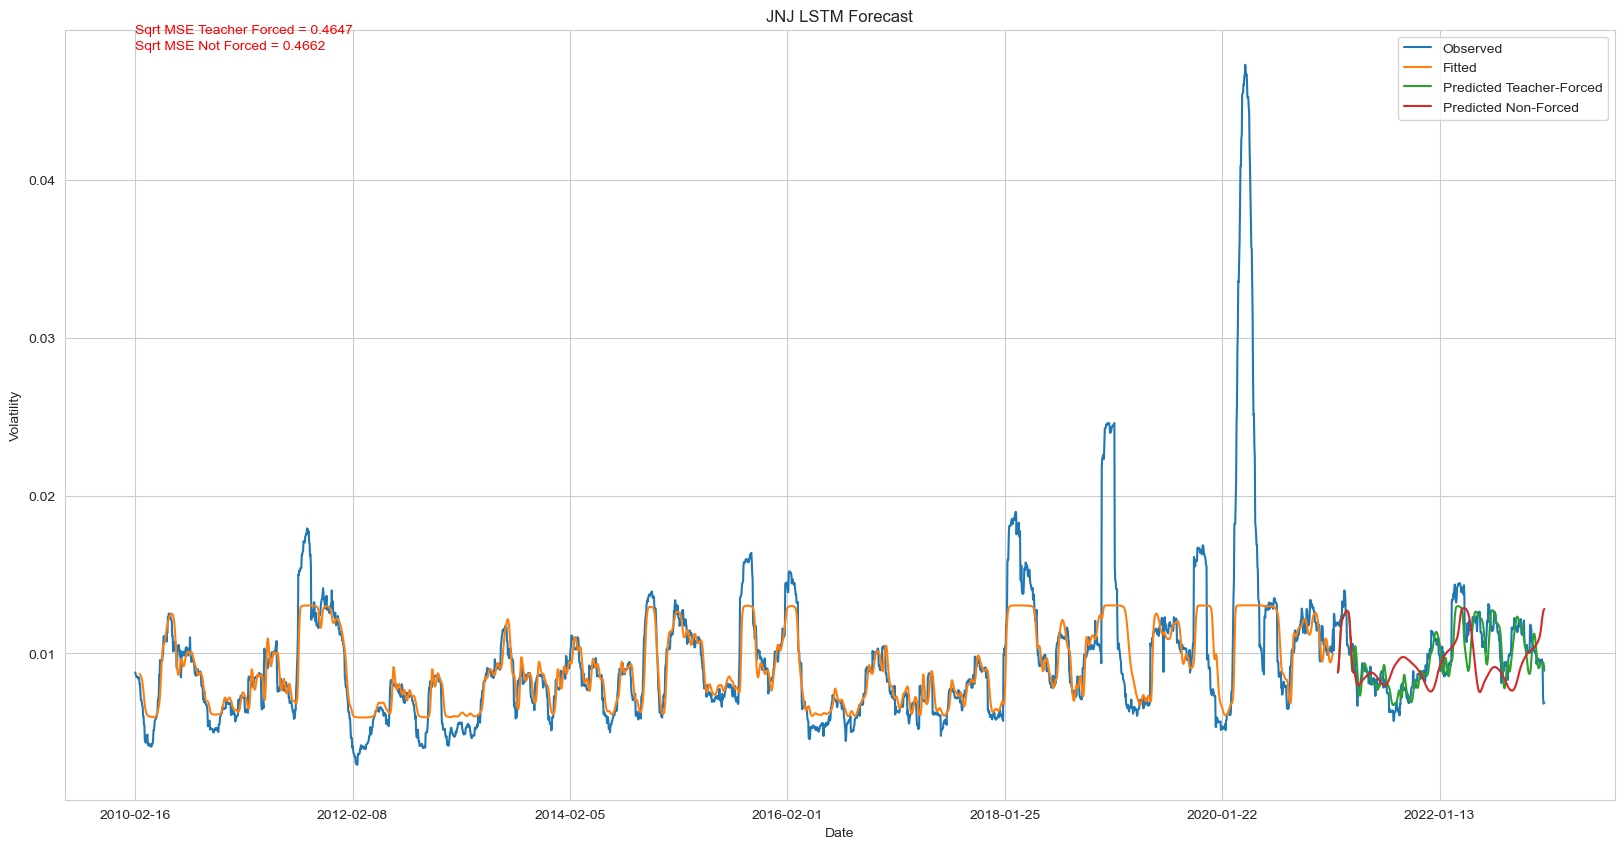

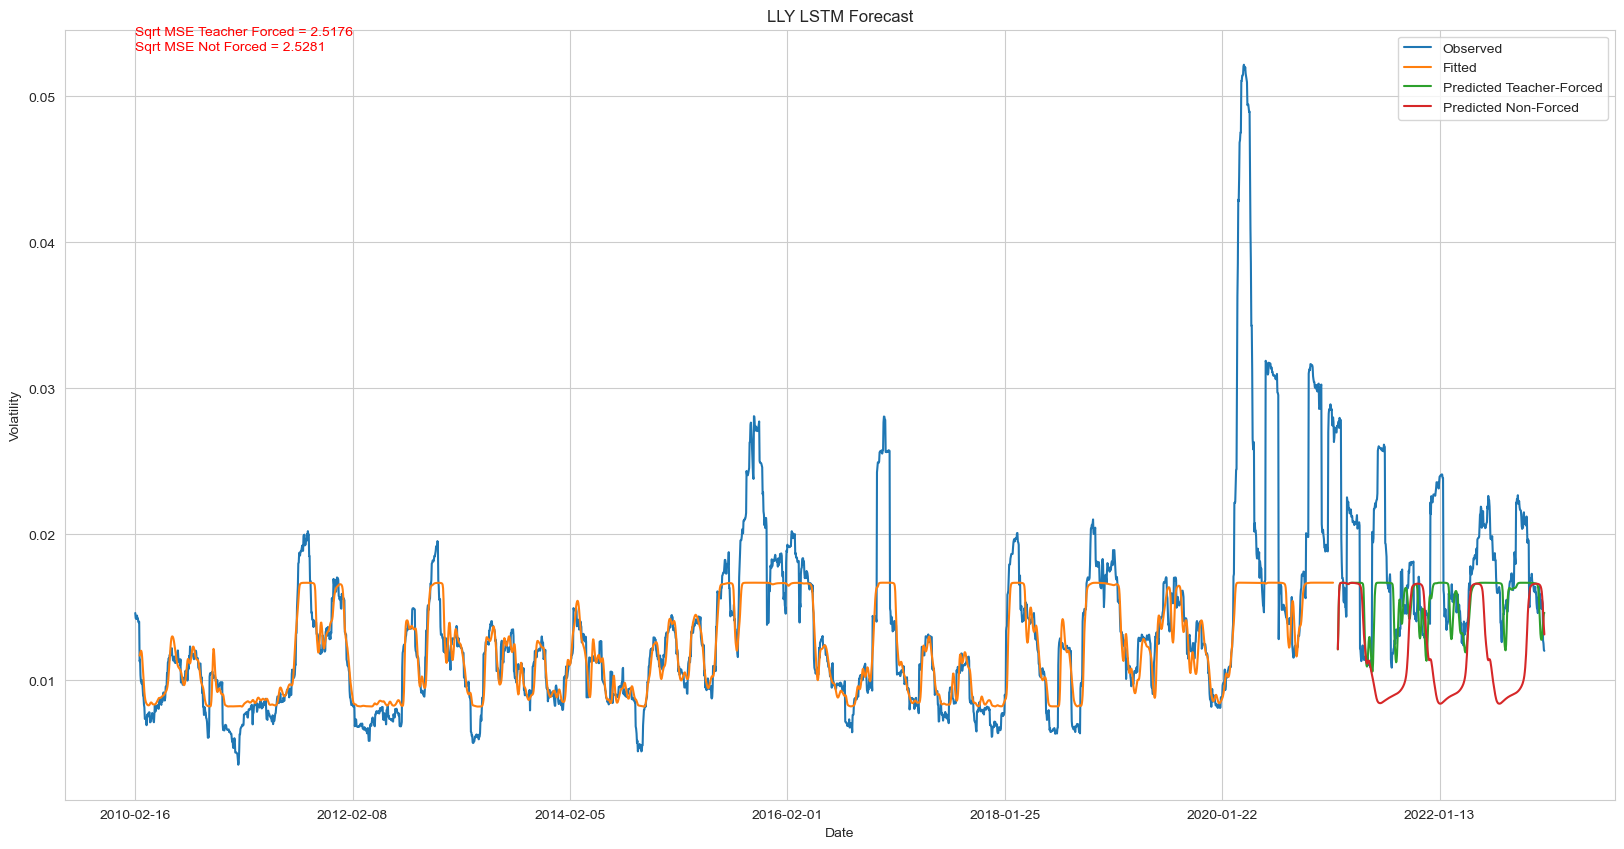

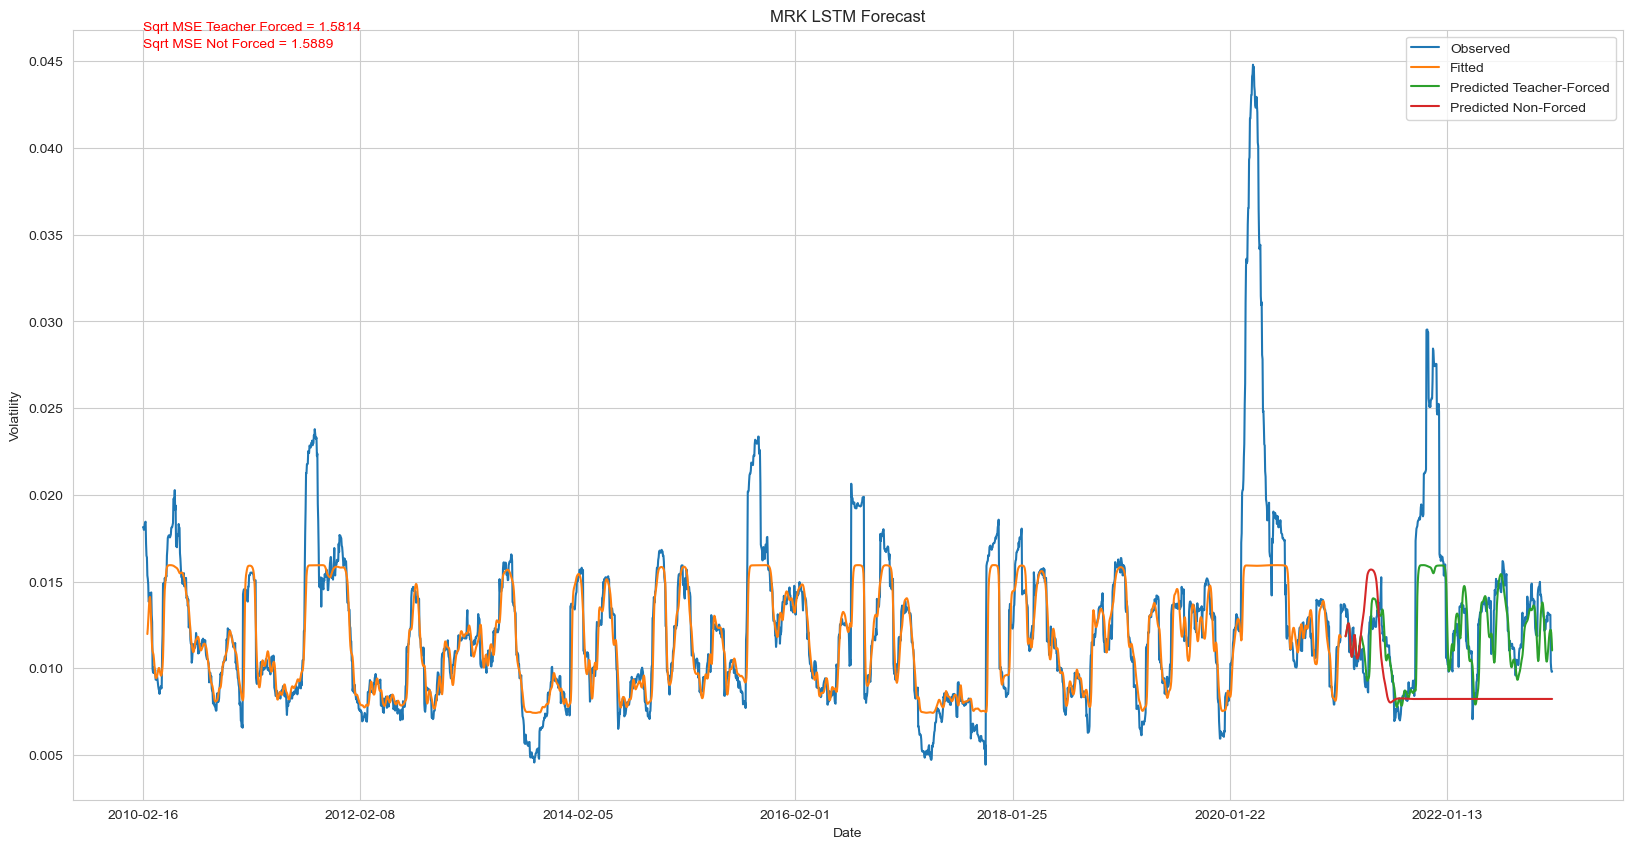

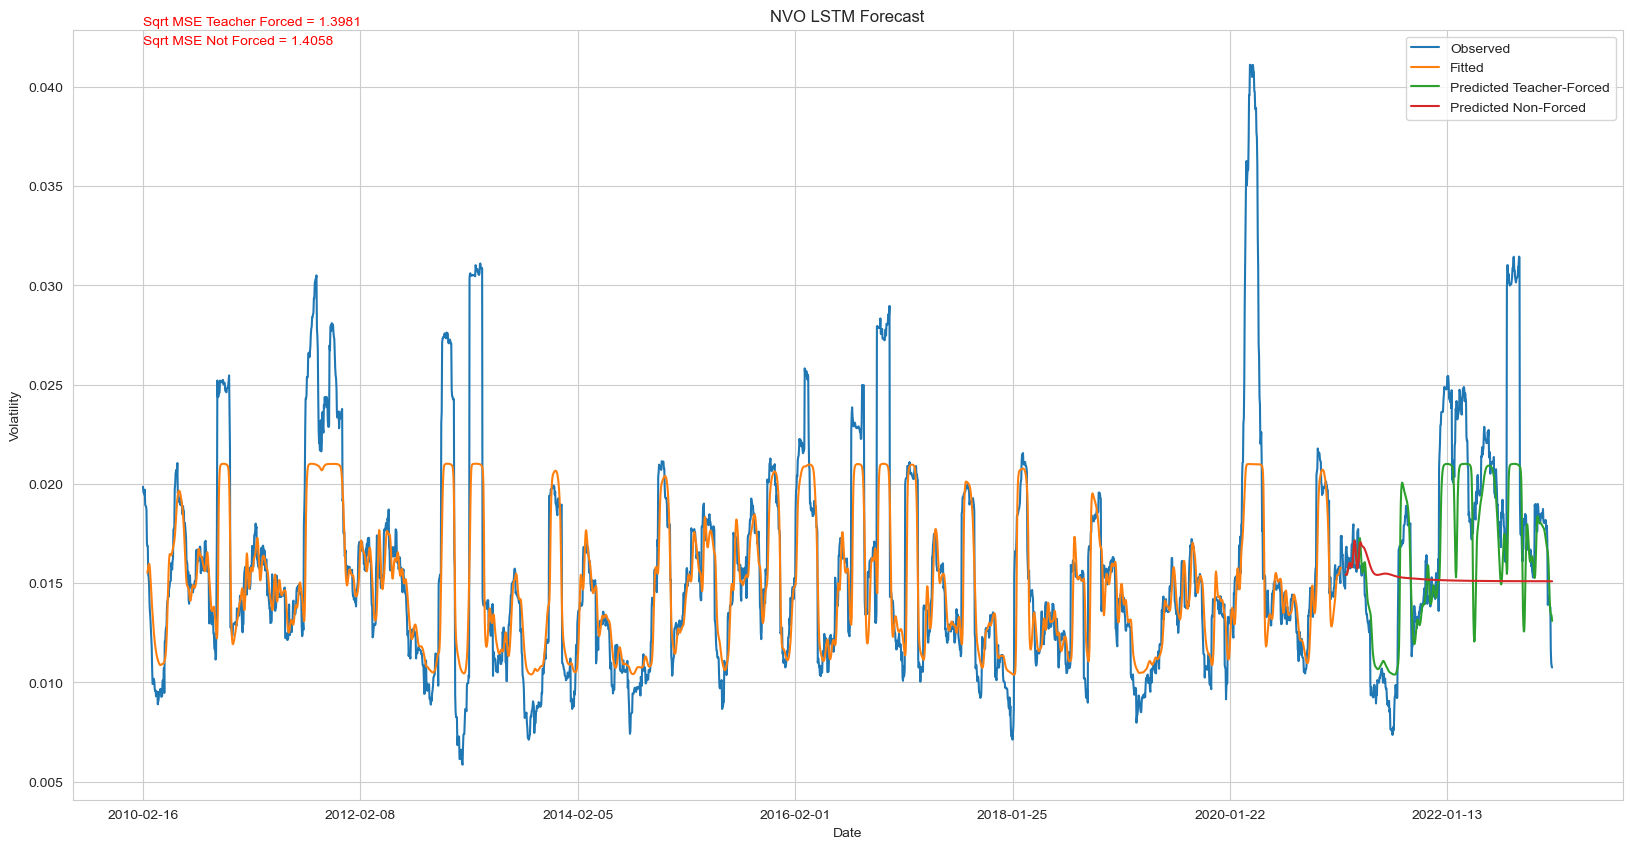

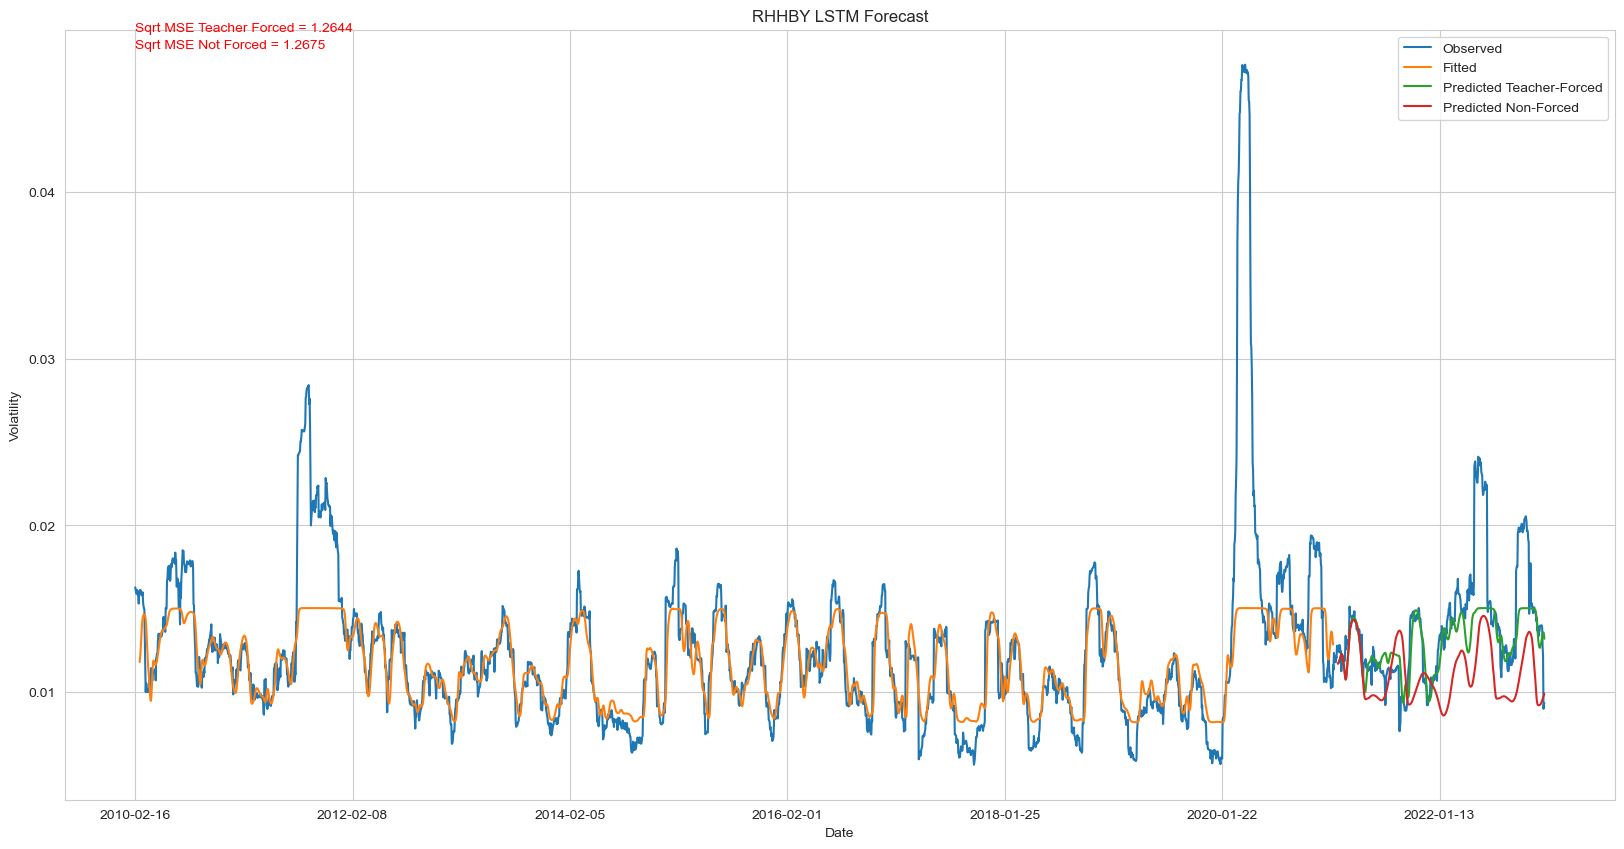

In [19]:
biotech_test_mses = {}

with torch.no_grad():
    for stock in biotech_tickers:
        window=10

        full_train = pd.concat([biotech_train, biotech_val])
        train_tensor = torch.tensor(full_train[f'{stock}_volatility'].values, dtype=torch.float)
        mean, std = biotech_means[stock], biotech_stds[stock]
        train_tensor = (train_tensor - mean) / std

        test_tensor = torch.tensor(biotech_test[f'{stock}_volatility'].values, dtype=torch.float)
        test_tensor = (test_tensor - mean) / std

        X_train = train_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
        y_train = train_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)

        X_test = test_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
        y_test = test_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)

        model = biotech_models[stock]

        fitted, _ = model(X_train)
        pred_forced, _ = model(X_test)
        # predicting the values given a 30 day initial set
        pred_infer = model.predict(X_test[:, :30, :], n_days=y_test.size(1) - 30, keep_init=True)
        
        fitted = (fitted * std) + mean
        pred_forced = (pred_forced * std) + mean
        pred_infer = (pred_infer * std) + mean

        criterion = torch.nn.MSELoss()
        loss_forced = criterion(pred_forced[:, :-1], y_test).item()
        loss_infer = criterion(pred_infer, y_test).item()

        ## make dataframes to be plotted
        obs_df = pd.DataFrame(data=biotech[f"{stock}_volatility"].values,
                              index=biotech.Date,
                              columns=["Observed"])

        fit_df = pd.DataFrame(data=fitted[:, :-1].squeeze().numpy(),
                              index=full_train.Date[window:],
                              columns=["Fitted"])

        pred_forced_df = pd.DataFrame(data=pred_forced[:, :-1].squeeze().numpy(),
                               index=biotech_test.Date[window:],
                               columns=["Predicted Teacher-Forced"])
        pred_infer_df = pd.DataFrame(data=pred_infer.squeeze().numpy(),
                                    index=biotech_test.Date[window:],
                                    columns=["Predicted Non-Forced"])

        df = pd.concat([obs_df, fit_df, pred_forced_df, pred_infer_df], axis=1)

        ## make the plot 
        ax = df.plot(y=["Observed", "Fitted", "Predicted Teacher-Forced", "Predicted Non-Forced"],
            figsize=(20,10),
            ylabel="Volatility",
            title=f"{stock} LSTM Forecast")
        ax.text(0,df["Observed"].max() + 0.002, f"Sqrt MSE Teacher Forced = {loss_forced:.4f}",
                color="red")
        ax.text(0,df["Observed"].max() + 0.001, f"Sqrt MSE Not Forced = {loss_infer:.4f}",
                color="red")

        biotech_test_mses[stock] = (loss_forced, loss_infer)


In [20]:
print_mse_results(biotech_test_mses)

Stock	Test MSE Forced		Test MSE Not Forced
JNJ	0.4647308886051178	0.4661547541618347
LLY	2.517594575881958	2.5281198024749756
MRK	1.5814226865768433	1.5888745784759521
NVO	1.3981239795684814	1.4057775735855103
RHHBY	1.2644468545913696	1.267496943473816


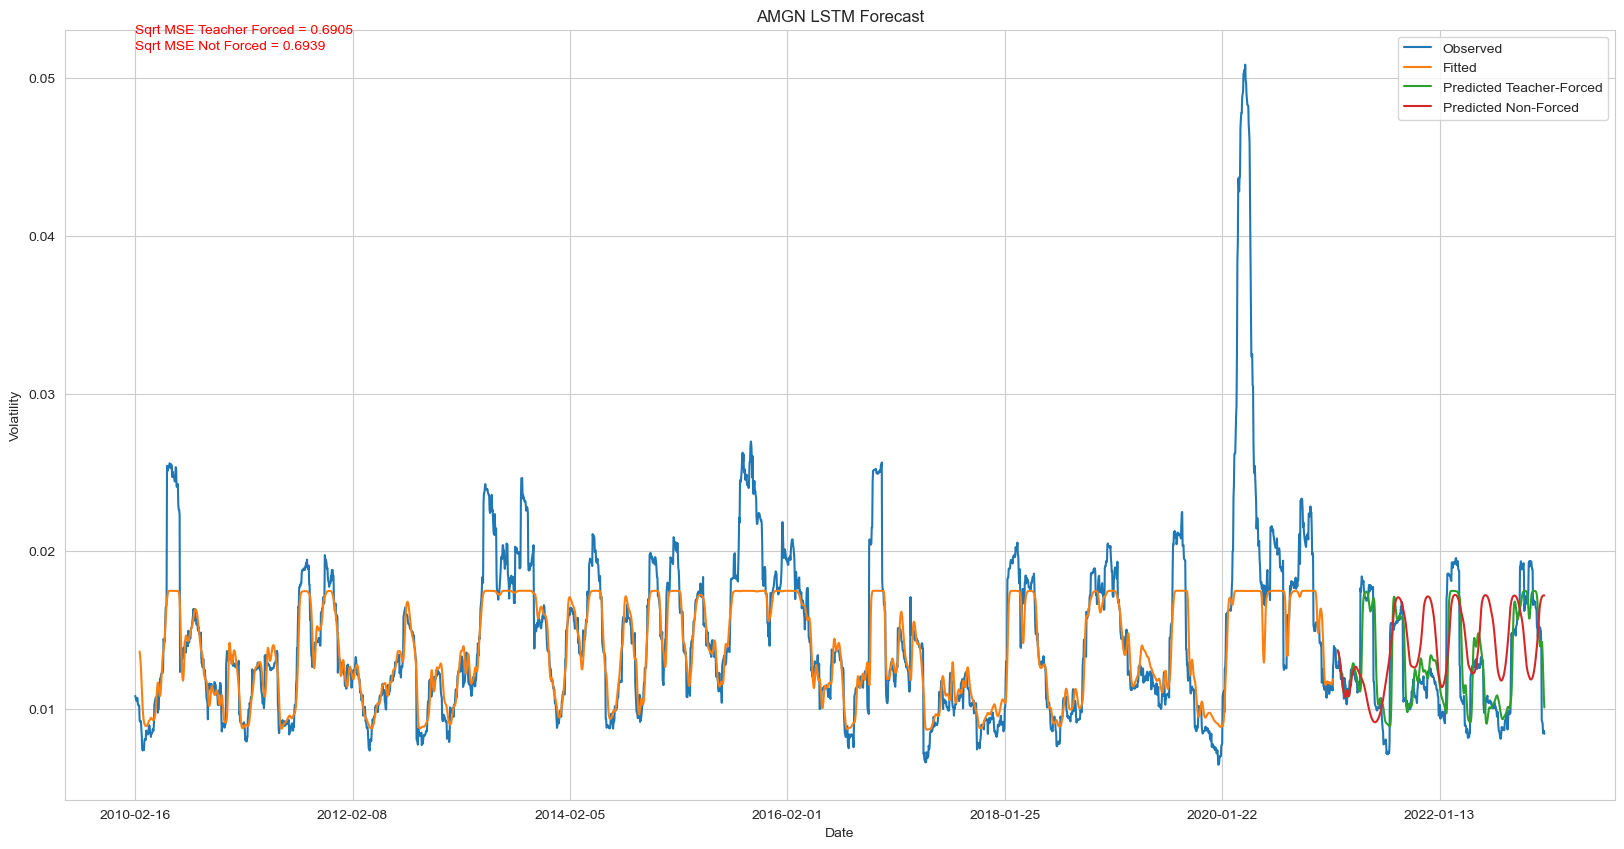

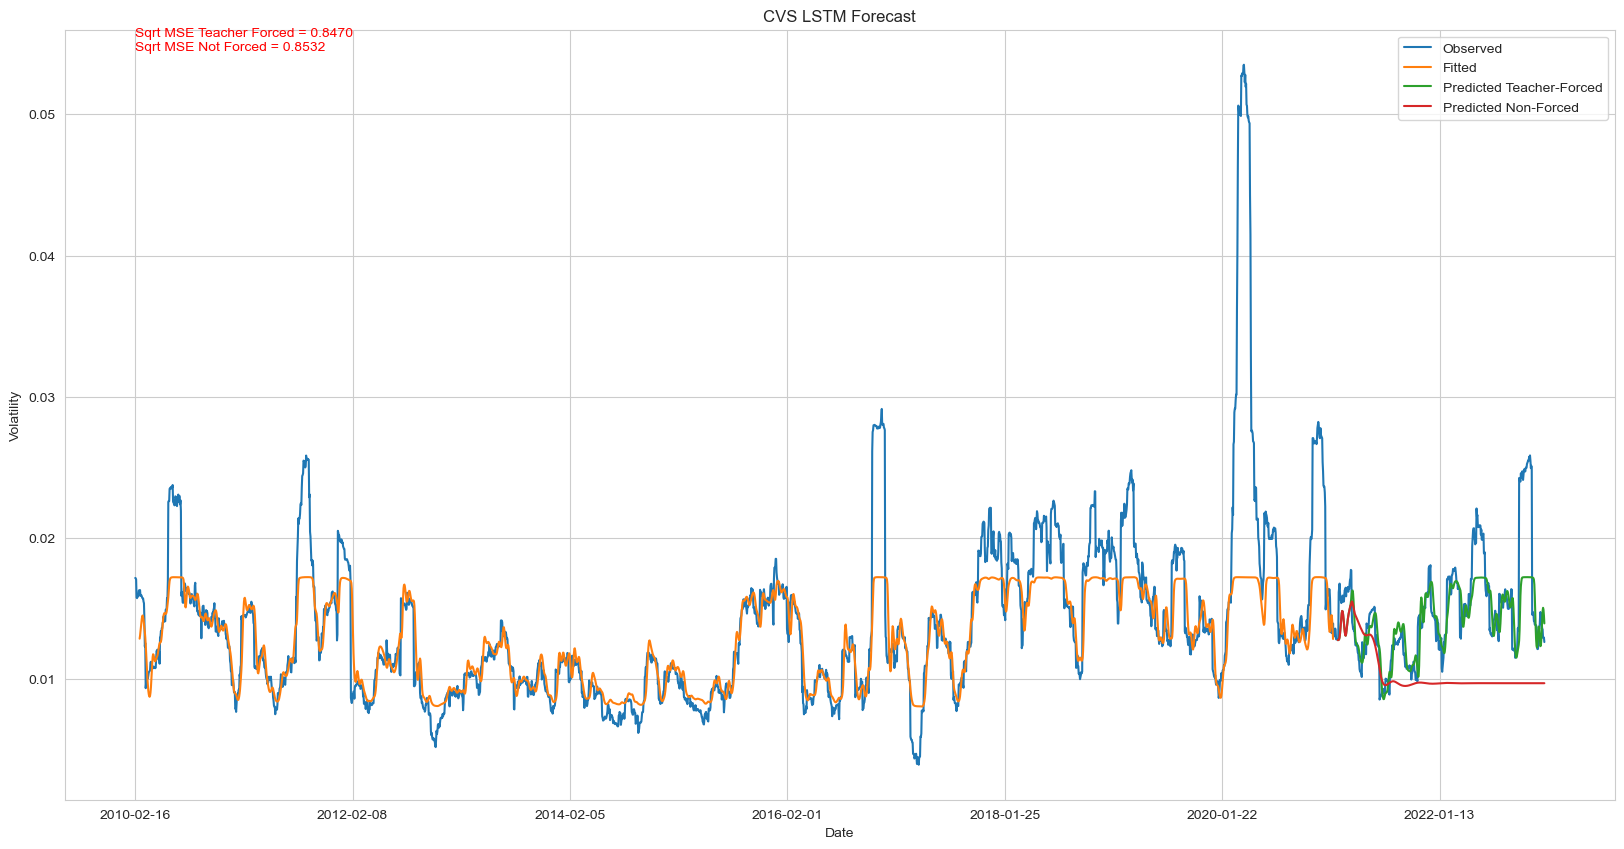

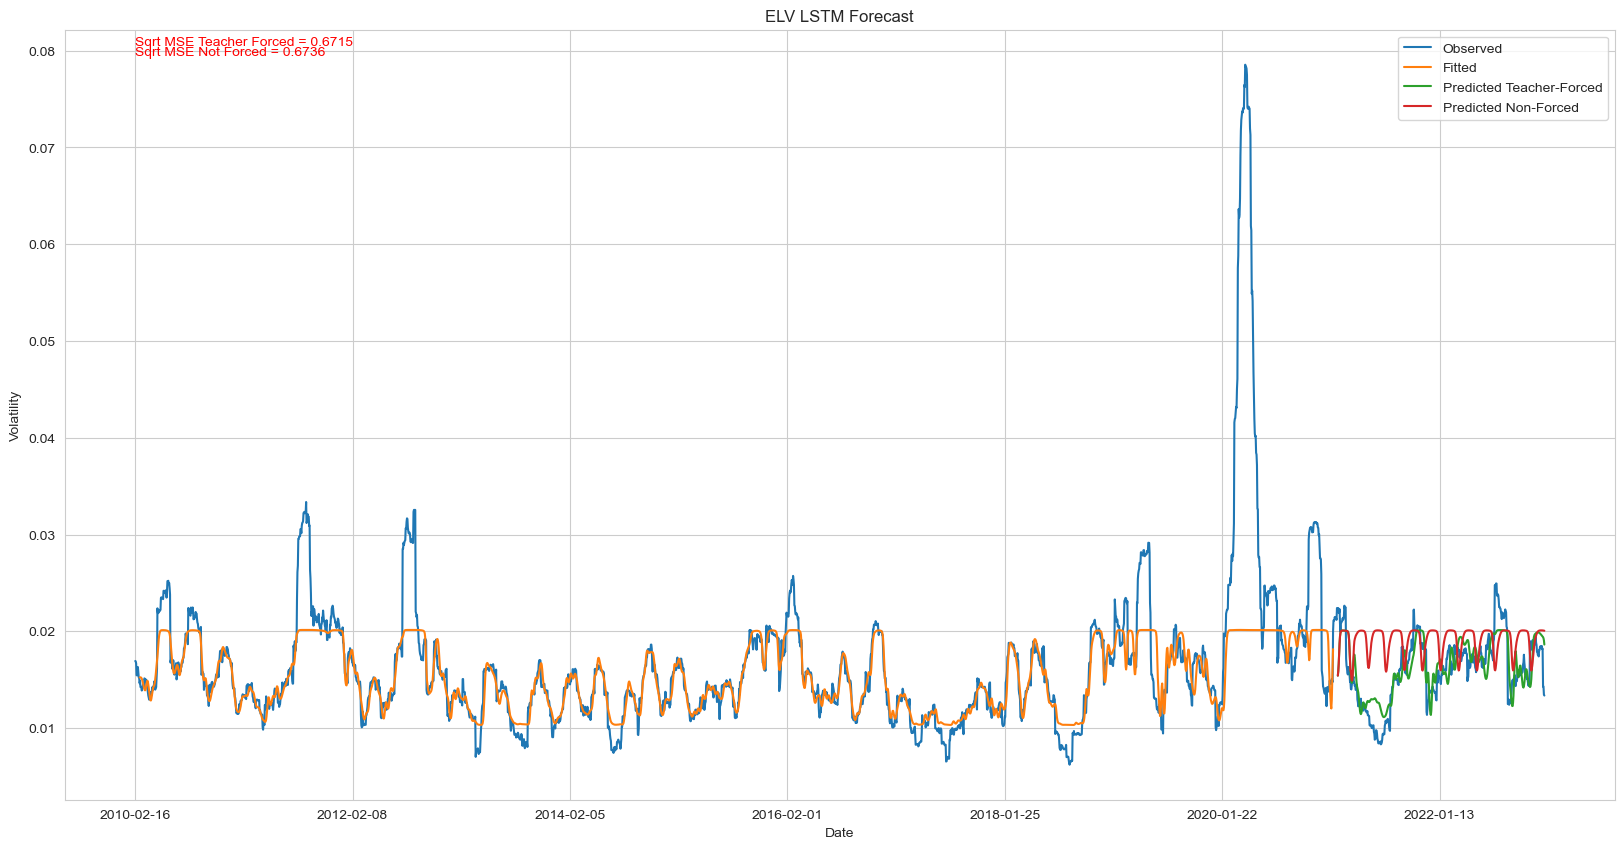

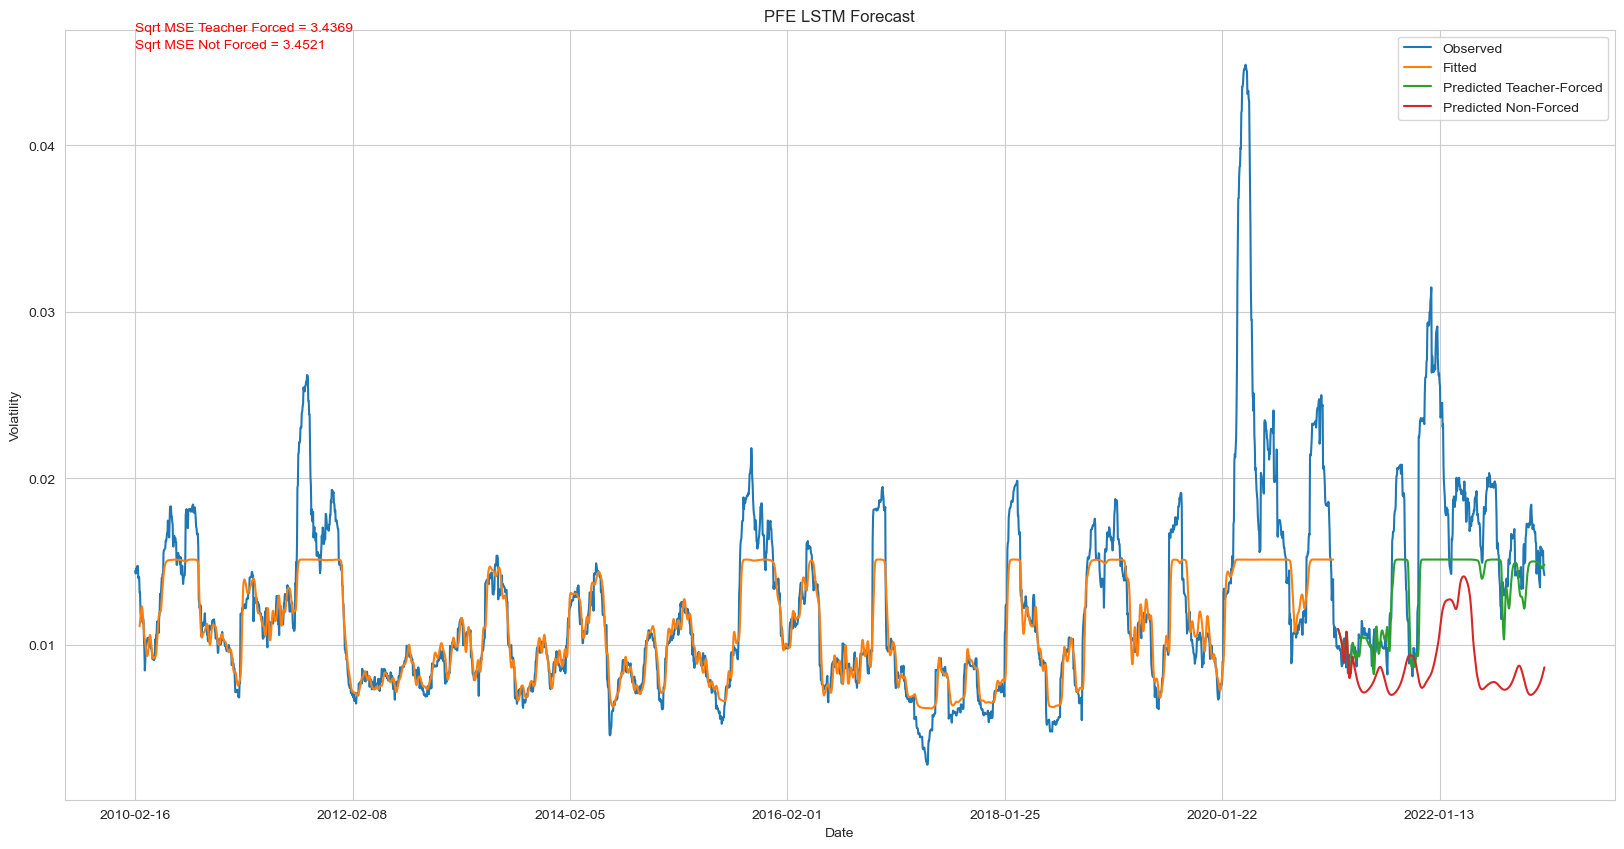

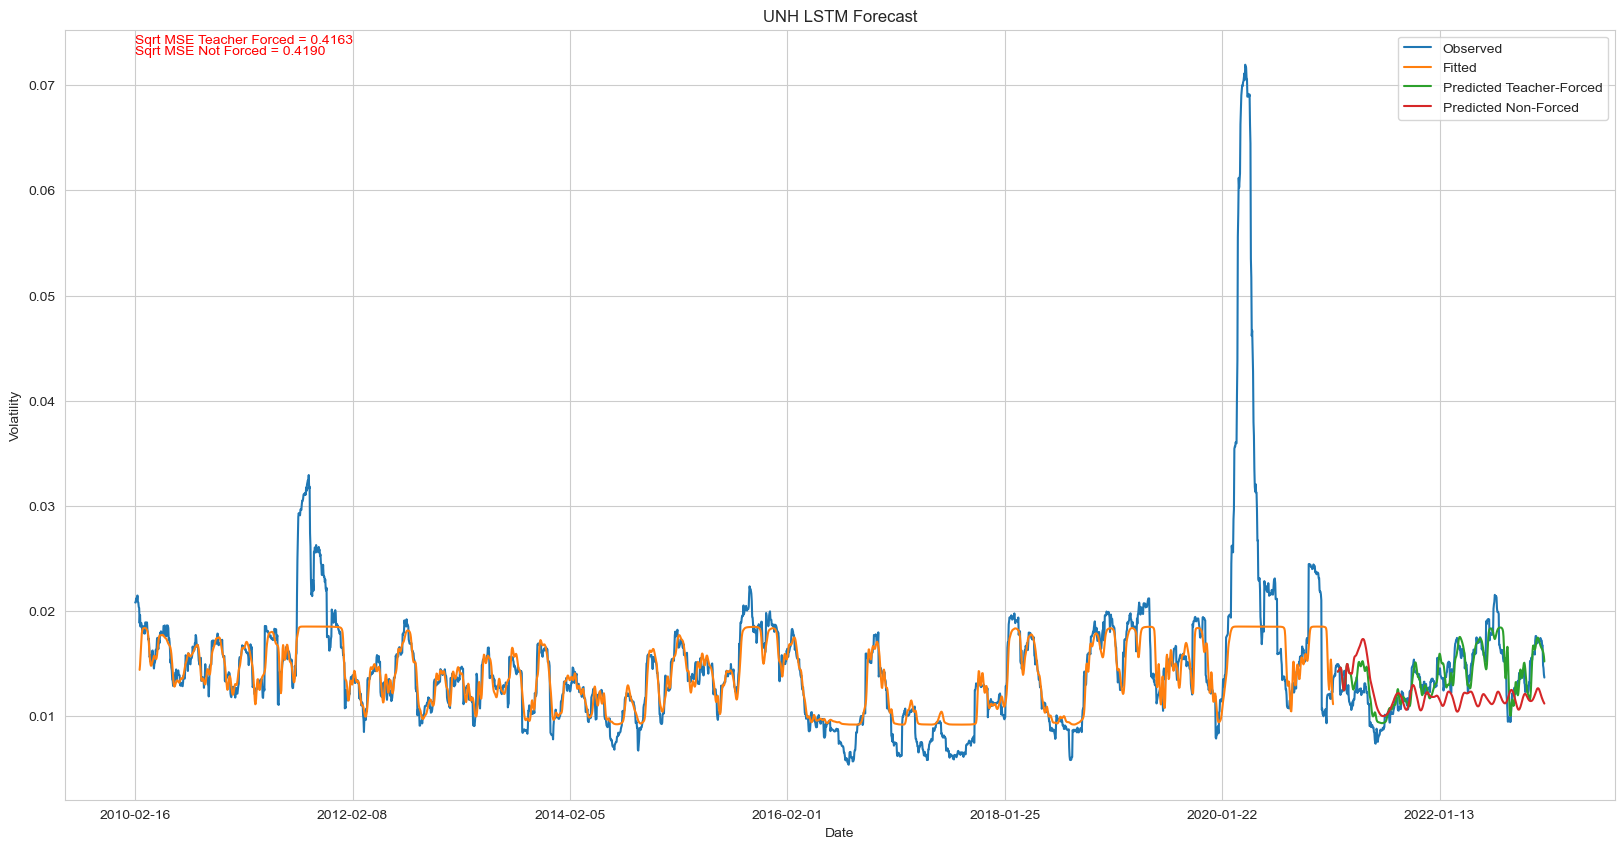

In [21]:
healthcare_test_mses = {}

with torch.no_grad():
    for stock in healthcare_tickers:
        window=10

        full_train = pd.concat([healthcare_train, healthcare_val])
        train_tensor = torch.tensor(full_train[f'{stock}_volatility'].values, dtype=torch.float)
        mean, std = healthcare_means[stock], healthcare_stds[stock]
        train_tensor = (train_tensor - mean) / std

        test_tensor = torch.tensor(healthcare_test[f'{stock}_volatility'].values, dtype=torch.float)
        test_tensor = (test_tensor - mean) / std

        X_train = train_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
        y_train = train_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)

        X_test = test_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
        y_test = test_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)

        model = healthcare_models[stock]

        fitted, _ = model(X_train)
        pred_forced, _ = model(X_test)
        # predicting the values given a 30 day initial set
        pred_infer = model.predict(X_test[:, :30, :], n_days=y_test.size(1) - 30, keep_init=True)
        
        fitted = (fitted * std) + mean
        pred_forced = (pred_forced * std) + mean
        pred_infer = (pred_infer * std) + mean

        criterion = torch.nn.MSELoss()
        loss_forced = criterion(pred_forced[:, :-1], y_test).item()
        loss_infer = criterion(pred_infer, y_test).item()

        ## make dataframes to be plotted
        obs_df = pd.DataFrame(data=healthcare[f"{stock}_volatility"].values,
                              index=healthcare.Date,
                              columns=["Observed"])

        fit_df = pd.DataFrame(data=fitted[:, :-1].squeeze().numpy(),
                              index=full_train.Date[window:],
                              columns=["Fitted"])

        pred_forced_df = pd.DataFrame(data=pred_forced[:, :-1].squeeze().numpy(),
                               index=healthcare_test.Date[window:],
                               columns=["Predicted Teacher-Forced"])
        pred_infer_df = pd.DataFrame(data=pred_infer.squeeze().numpy(),
                                    index=healthcare_test.Date[window:],
                                    columns=["Predicted Non-Forced"])

        df = pd.concat([obs_df, fit_df, pred_forced_df, pred_infer_df], axis=1)

        ## make the plot 
        ax = df.plot(y=["Observed", "Fitted", "Predicted Teacher-Forced", "Predicted Non-Forced"],
            figsize=(20,10),
            ylabel="Volatility",
            title=f"{stock} LSTM Forecast")
        ax.text(0,df["Observed"].max() + 0.002, f"Sqrt MSE Teacher Forced = {loss_forced:.4f}",
                color="red")
        ax.text(0,df["Observed"].max() + 0.001, f"Sqrt MSE Not Forced = {loss_infer:.4f}",
                color="red")

        healthcare_test_mses[stock] = (loss_forced, loss_infer)


In [22]:
print_mse_results(healthcare_test_mses)

Stock	Test MSE Forced		Test MSE Not Forced
AMGN	0.6904674768447876	0.6939202547073364
CVS	0.8470091223716736	0.8532123565673828
ELV	0.6714692115783691	0.6735673546791077
PFE	3.4368529319763184	3.4520561695098877
UNH	0.41629210114479065	0.41901904344558716


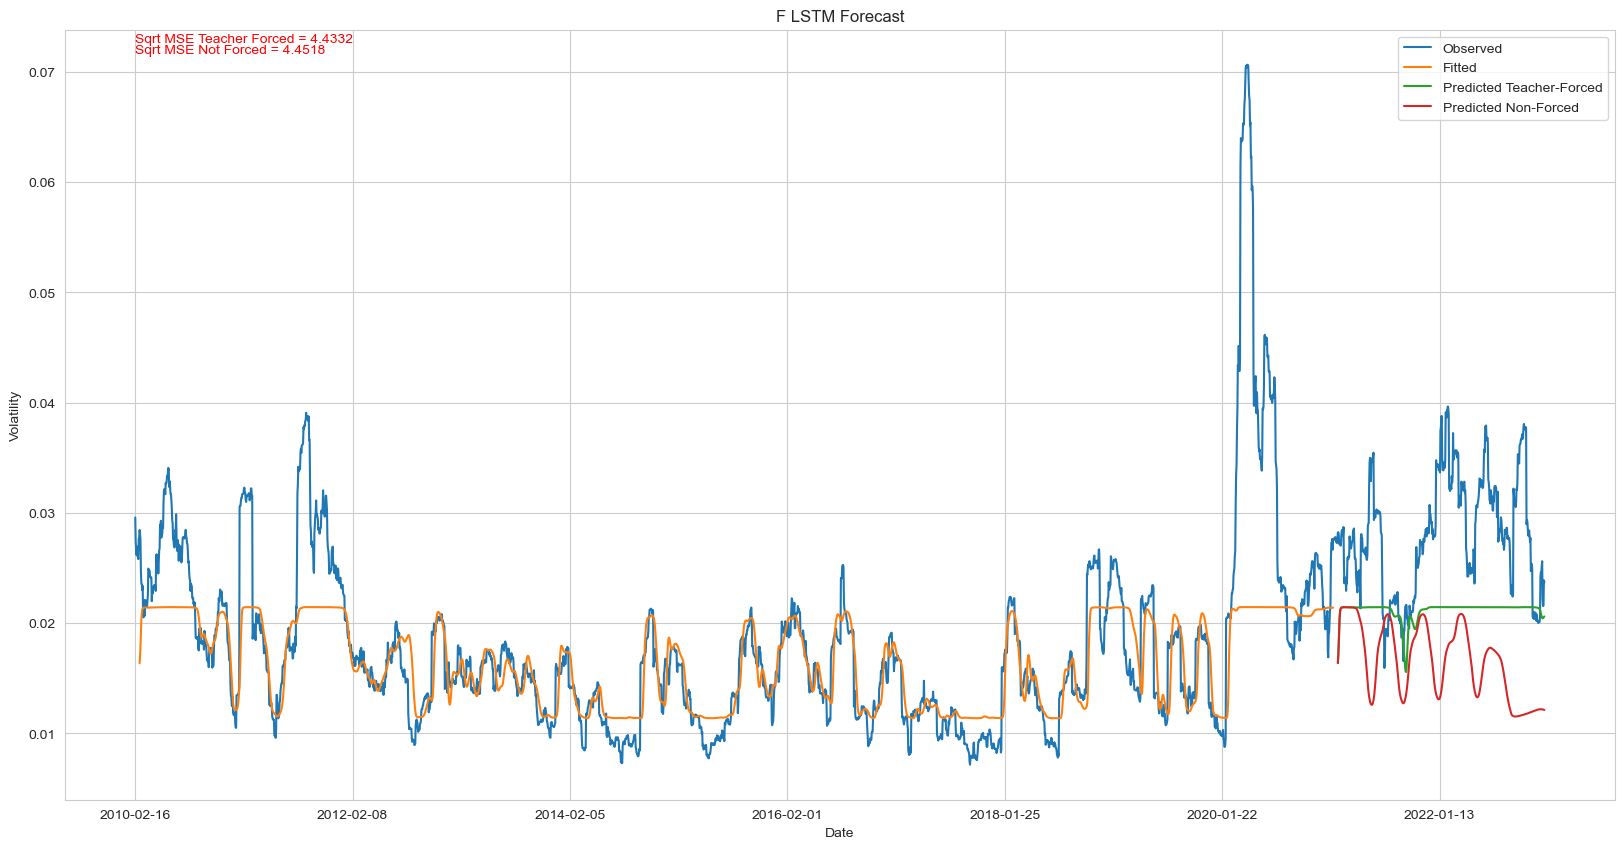

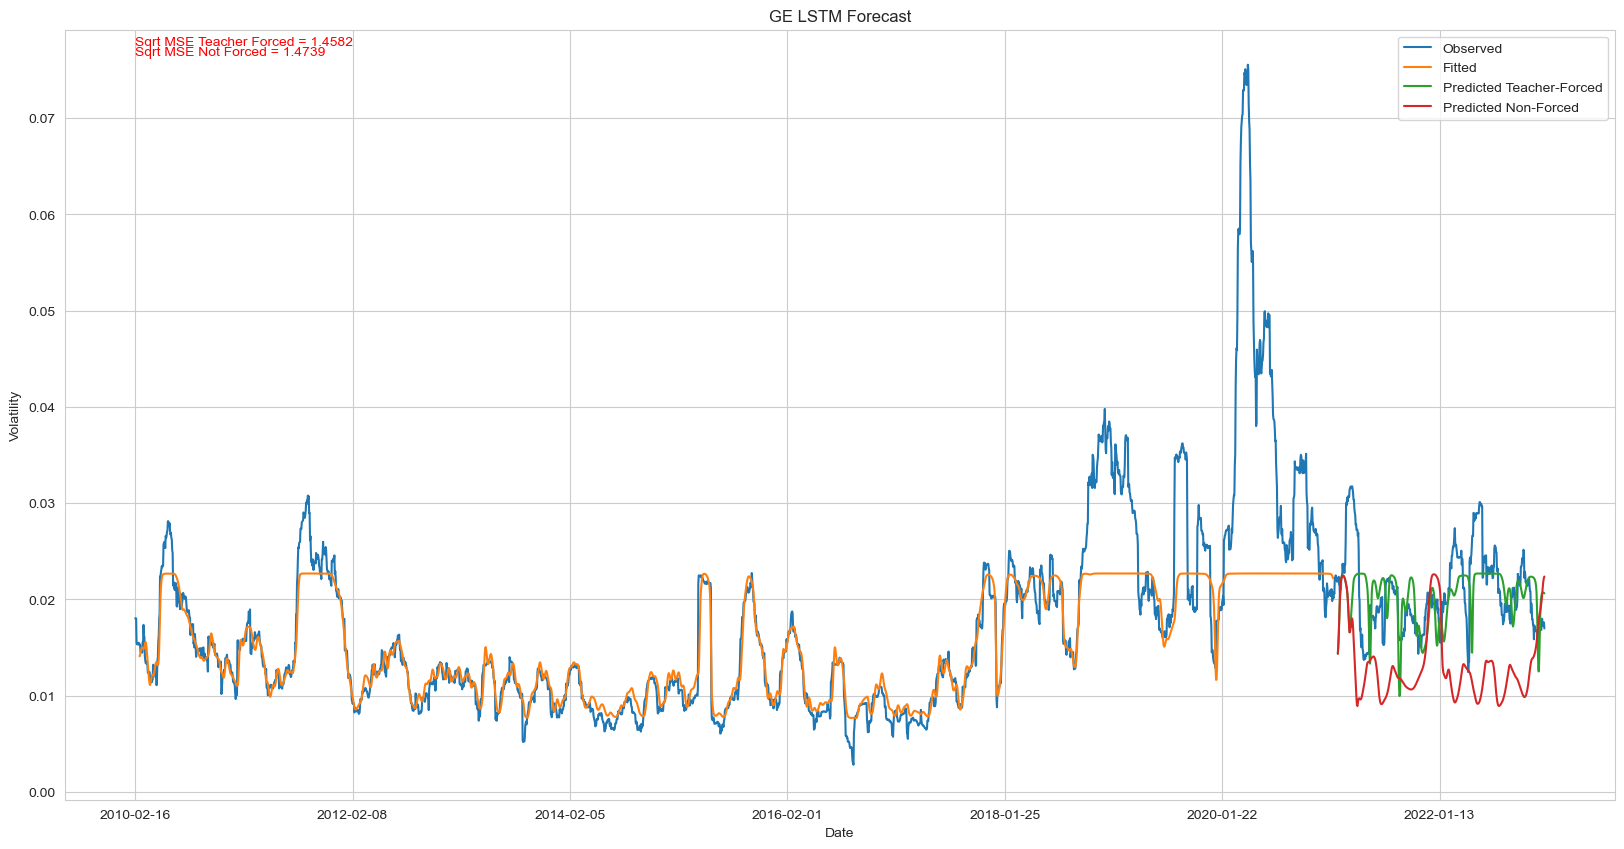

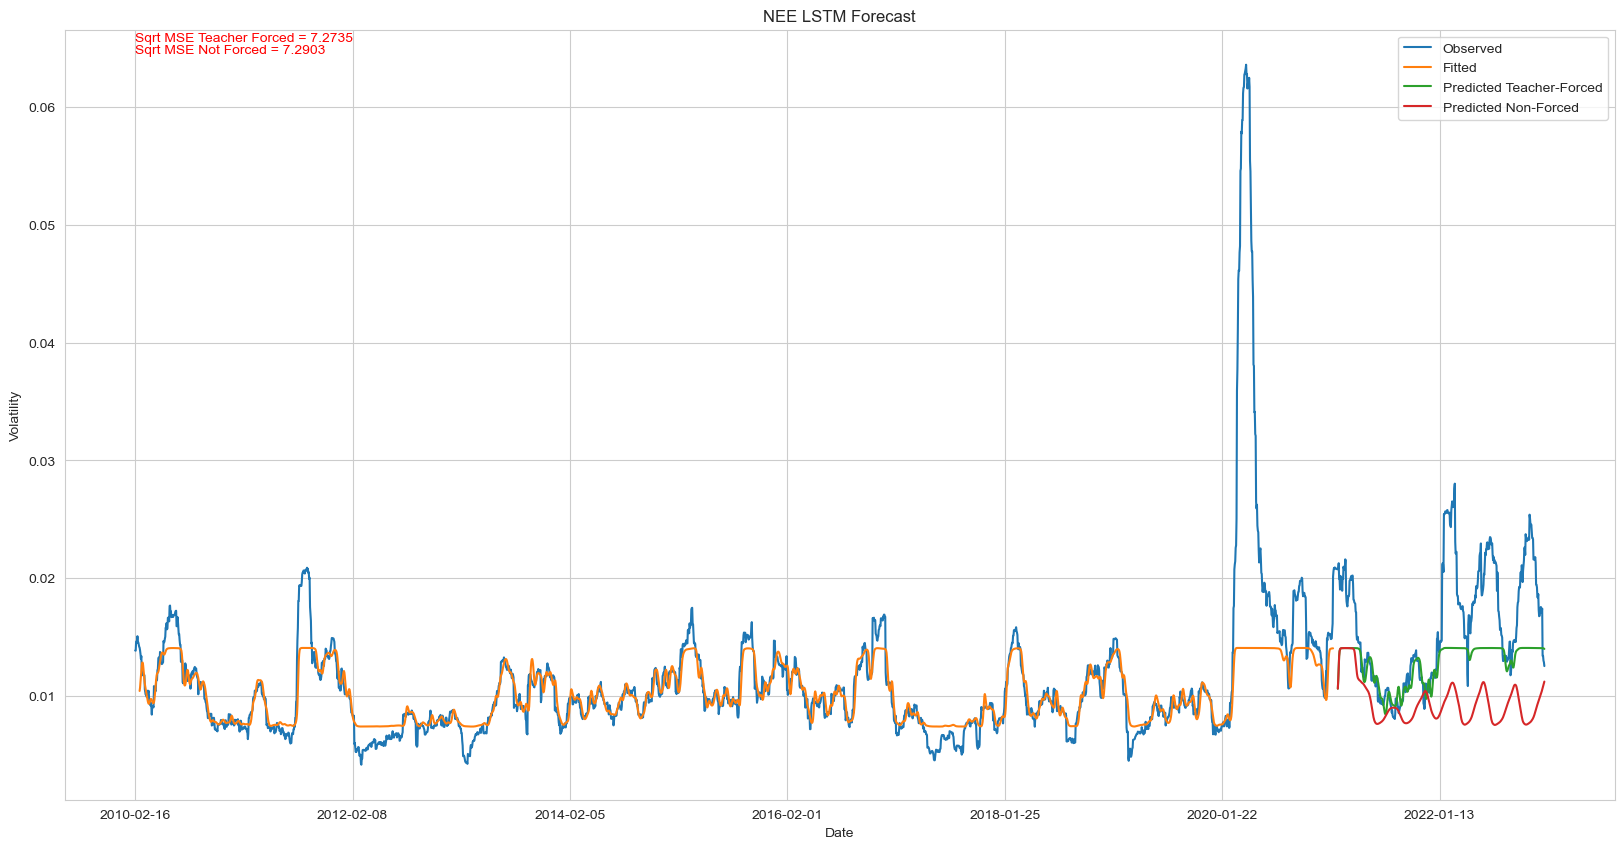

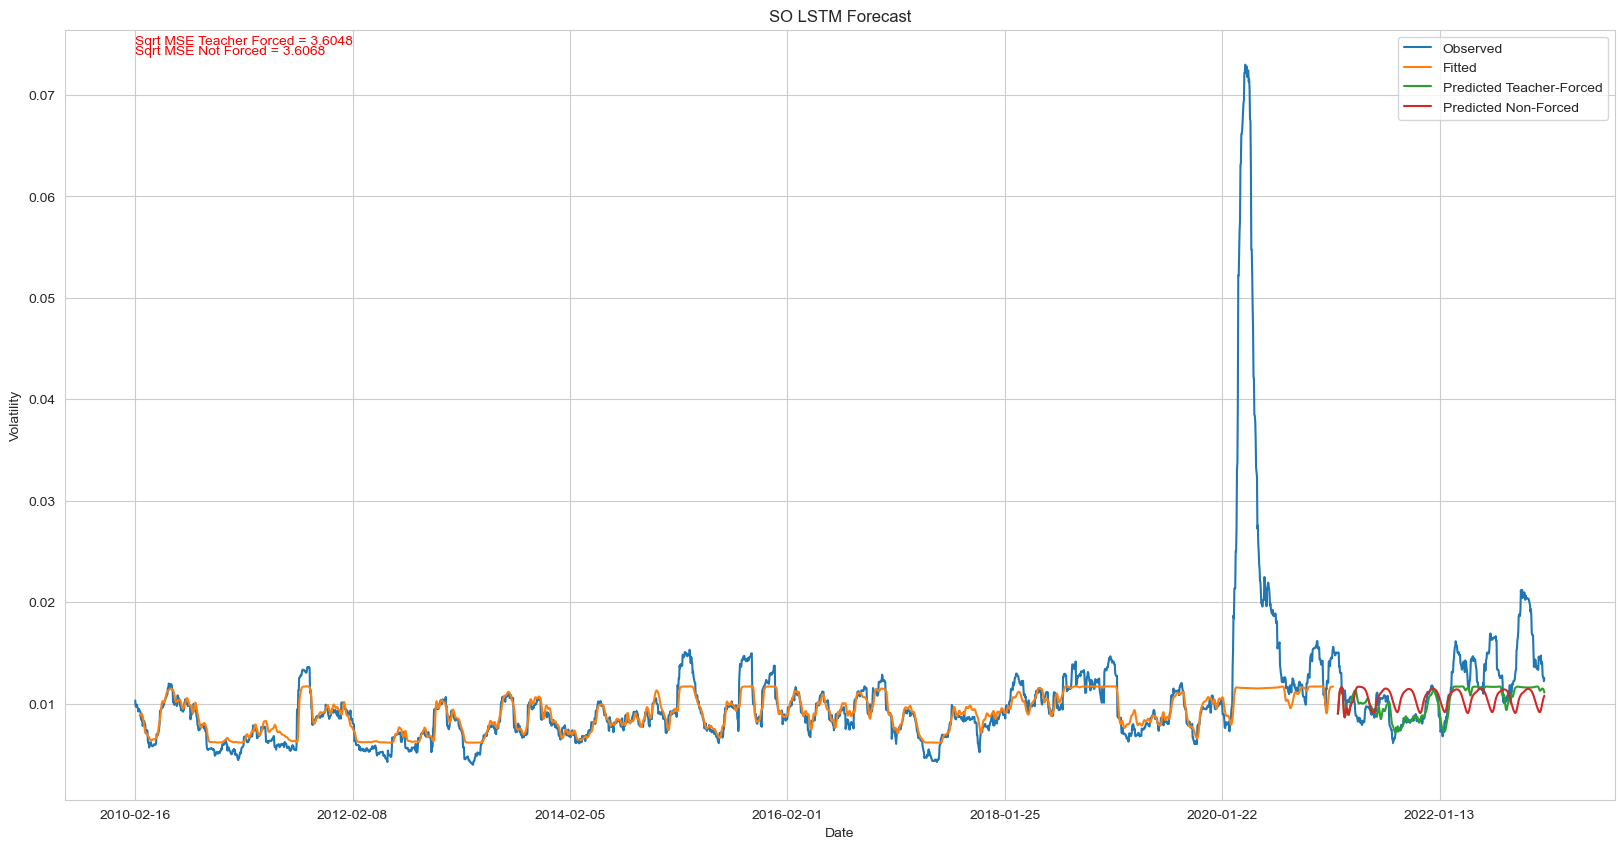

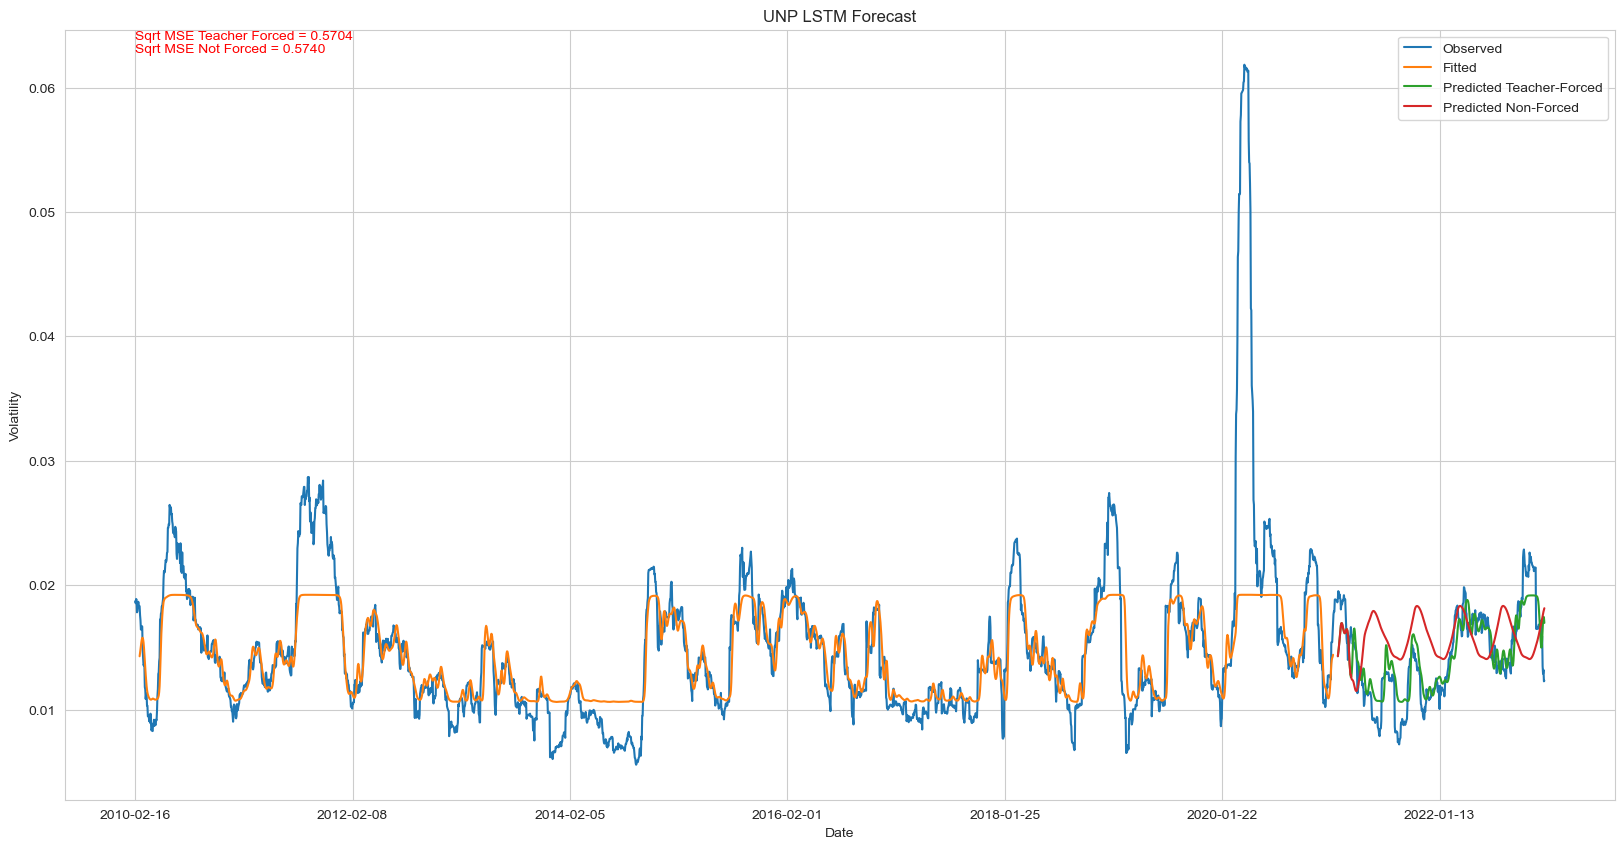

In [23]:
industrial_test_mses = {}

with torch.no_grad():
    for stock in industrial_tickers:
        window=10

        full_train = pd.concat([industrial_train, industrial_val])
        train_tensor = torch.tensor(full_train[f'{stock}_volatility'].values, dtype=torch.float)
        mean, std = industrial_means[stock], industrial_stds[stock]
        train_tensor = (train_tensor - mean) / std

        test_tensor = torch.tensor(industrial_test[f'{stock}_volatility'].values, dtype=torch.float)
        test_tensor = (test_tensor - mean) / std

        X_train = train_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
        y_train = train_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)

        X_test = test_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
        y_test = test_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)

        model = industrial_models[stock]

        fitted, _ = model(X_train)
        pred_forced, _ = model(X_test)
        # predicting the values given a 30 day initial set
        pred_infer = model.predict(X_test[:, :30, :], n_days=y_test.size(1) - 30, keep_init=True)
        
        fitted = (fitted * std) + mean
        pred_forced = (pred_forced * std) + mean
        pred_infer = (pred_infer * std) + mean

        criterion = torch.nn.MSELoss()
        loss_forced = criterion(pred_forced[:, :-1], y_test).item()
        loss_infer = criterion(pred_infer, y_test).item()

        ## make dataframes to be plotted
        obs_df = pd.DataFrame(data=industrial[f"{stock}_volatility"].values,
                              index=industrial.Date,
                              columns=["Observed"])

        fit_df = pd.DataFrame(data=fitted[:, :-1].squeeze().numpy(),
                              index=full_train.Date[window:],
                              columns=["Fitted"])

        pred_forced_df = pd.DataFrame(data=pred_forced[:, :-1].squeeze().numpy(),
                               index=industrial_test.Date[window:],
                               columns=["Predicted Teacher-Forced"])
        pred_infer_df = pd.DataFrame(data=pred_infer.squeeze().numpy(),
                                    index=industrial_test.Date[window:],
                                    columns=["Predicted Non-Forced"])

        df = pd.concat([obs_df, fit_df, pred_forced_df, pred_infer_df], axis=1)

        ## make the plot 
        ax = df.plot(y=["Observed", "Fitted", "Predicted Teacher-Forced", "Predicted Non-Forced"],
            figsize=(20,10),
            ylabel="Volatility",
            title=f"{stock} LSTM Forecast")
        ax.text(0,df["Observed"].max() + 0.002, f"Sqrt MSE Teacher Forced = {loss_forced:.4f}",
                color="red")
        ax.text(0,df["Observed"].max() + 0.001, f"Sqrt MSE Not Forced = {loss_infer:.4f}",
                color="red")

        industrial_test_mses[stock] = (loss_forced, loss_infer)


In [24]:
print_mse_results(industrial_test_mses)

Stock	Test MSE Forced		Test MSE Not Forced
F	4.433236598968506	4.451827526092529
GE	1.4582220315933228	1.4739329814910889
NEE	7.273499011993408	7.29026985168457
SO	3.604771375656128	3.6068167686462402
UNP	0.5704018473625183	0.5739935636520386
